In [1]:
from __future__ import print_function
import random
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import time
import math
from scipy import linalg
from game import Board, Game
from mcts_alphaZero import MCTSPlayer
from policy_value_net_tensorflow import PolicyValueNet 
from pretrain import pretraind


def runqzero(sample,case,pptrain,exploration,game_batch_num,lr,ini):
    
    class TrainPipeline():
        def __init__(self, init_model=None):
            time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))

            # params of the board and the game
            self.board_width = 20      #N-qubit    divide
            self.board_height = 5    # N-modular     frequency

            self.Mheight=21         #M-clause
            self.Nwidth=7        #N-qubit
            self.Nqubit=self.Nwidth
            self.T=70

            print("sample",sample,"case",case)
            #resultcc=np.loadtxt('sat'+str(self.Nqubit)+'-result1.txt')       #training data
            resultcc=np.loadtxt('sat'+str(self.Nqubit)+'-result2.txt')      #test data
            resultc1=resultcc.tolist()
            print("result",len(resultc1))
            result=[int(x) for x in resultc1[sample]]  #pretrain data
        
            #hh=np.loadtxt('sat'+str(self.Nqubit)+'-info1.txt')   
            hh=np.loadtxt('sat'+str(self.Nqubit)+'-info2.txt')  
            Hinfo=hh.tolist()
            print("Hinfo",len(Hinfo))
            Hi=Hinfo[sample]
                  
            
            print("ini",ini)
            self.board = Board(ini,self.T,self.Nqubit,result,Hi,height=self.board_height,width=self.board_width,Mheight=self.Mheight,Nwidth=self.Nwidth)
            self.game = Game(self.board)

            # training params
            self.n_playout =10  # num of simulations for each move                             ~~~~~~~~~~~~~~~~~~~~~~~~修改8.26
            self.game_batch_num = game_batch_num
            self.batch_size = 20 # mini-batch size for training

            self.learn_rate =lr
            self.lr_multiplier = 1.0  # adaptively adjust the learning rate based on KL
            self.temp = 1.0  # the temperature param
            self.c_puct =3  #explore



            self.buffer_size = 10000
            self.data_buffer = deque(maxlen=self.buffer_size)
            self.play_batch_size = 1
            self.epochs = 50  # num of train_steps for each update
            self.kl_targ = 0.02

            self.lossvalue=[]
            self.entropyvalue=[]
            self.energy=[]
            self.fidelity=[]
            self.step=0


            if init_model:
                print("init_model1",init_model)
                # start training from an initial policy-value net
                self.policy_value_net = PolicyValueNet(self.board_height,self.board_width,self.Mheight,self.Nwidth,model_file=init_model)
            else:
                print("init_model",init_model)
                # start training from a new policy-value net
                self.policy_value_net = PolicyValueNet(self.board_height,self.board_width,self.Mheight,self.Nwidth)




        def collect_selfplay_data(self, n_games=1,cc_puct=2,plore=1):

            self.mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn,c_puct=cc_puct,n_playout=self.n_playout,is_selfplay=plore)

            for i in range(n_games):

                winner, play_data, energy,overlap = self.game.start_self_play(self.mcts_player,temp=self.temp)

                self.energy.append(energy)
                self.fidelity.append(overlap)
                play_data = list(play_data)[:] 
                self.episode_len = len(play_data)
                self.data_buffer.extend(play_data)     



        def policy_update(self):
            """update the policy-value net"""

            mini_batch = random.sample(self.data_buffer, self.batch_size)

            
            good_batch=[]
            for da in self.data_buffer:
                if da[2]==10:
                    good_batch.append(da)
            #print("good_batch:",good_batch)
                    
            train_batch=mini_batch+good_batch
            
            state_batch = [data[0] for data in train_batch]
            mcts_probs_batch = [data[1] for data in train_batch]
            winner_batch = [data[2] for data in train_batch]
            
            print("train_length:",len(train_batch))

            old_probs, old_v = self.policy_value_net.policy_value(state_batch)
            for i in range(self.epochs):
                loss, entropy = self.policy_value_net.train_step(state_batch,mcts_probs_batch,winner_batch,self.learn_rate*self.lr_multiplier)


                new_probs, new_v = self.policy_value_net.policy_value(state_batch)
                kl = np.mean(np.sum(old_probs * (np.log(old_probs + 1e-10) - np.log(new_probs + 1e-10)),axis=1) )            

            if self.step>150:
                self.lr_multiplier=0.5            
            if self.step>300:
                self.lr_multiplier=0.3
                self.batch_size=60
            if self.step>400:
                self.lr_multiplier=0.1
                self.batch_size=100




            self.lossvalue.append(loss)
            self.entropyvalue.append(entropy)
            print(("kl:{:.5f},""lr_multiplier:{:.3f},""loss:{},""entropy:{}").format(kl,self.lr_multiplier,loss,entropy))
            return loss, entropy



        def run(self):     

            for i in range(self.game_batch_num):  
                self.step=self.step+1
                self.collect_selfplay_data(self.play_batch_size,8,0)

                print("batch i:{}, episode_len:{}".format(i+1, self.episode_len))
                print("~~~~~~~~~~~~~~~~~~~~~~")
                
                if len(self.data_buffer) > self.batch_size:
                    loss, entropy = self.policy_update()






        def run2(self):     

            for i in range(int(self.game_batch_num/2)):   
                self.step=self.step+1
                self.collect_selfplay_data(self.play_batch_size,0.5,0)

                print("batch i:{}, episode_len:{}".format(i+1, self.episode_len))
                print("~~~~~~~~~~~~~~~~~~~~~~")

                if len(self.data_buffer) > self.batch_size:
                    loss, entropy = self.policy_update()




        def run1(self):     


                plt.plot(self.energy,label="energy")
                plt.ylim(0,1)
                plt.legend()
                plt.show()
                plt.plot(self.fidelity,label="fidelity")
                plt.ylim(0,1)
                plt.legend()
                
                
                filename='qzero'+"s"+str(sample)+"c"+str(case)
                np.savetxt(filename+'fidelity.txt', np.array(self.fidelity))
                plt.savefig(filename+'fidelity.jpg')
                plt.show()



        def prerun(self):   

            learn_rate= 2e-3
            lr_multiplier= 1.0
            epochs=200

            fgood='sat'+str(self.Nqubit)+"-"+str(self.T)+'train.txt'
            finfo='sat'+str(self.Nqubit)+'-info1.txt'
            
            state_batch2,mcts_probs_batch,winner_batch=pretraind.pretraindata(fgood,finfo)


            lossvalue=[]
            entropyvalue=[]
            for i in range(epochs):
                loss, entropy = self.policy_value_net.train_step(state_batch2,mcts_probs_batch,winner_batch,learn_rate*lr_multiplier)   #batch1,batch2
                lossvalue.append(loss)
                entropyvalue.append(entropy)


            plt.plot(lossvalue) 
            plt.show()
            





    if __name__ == '__main__':


        training_pipeline = TrainPipeline()
        
    if pptrain==1:
        training_pipeline.prerun()

    if exploration==1:
        training_pipeline.run()    # strong explore
    training_pipeline.run2()   #weak explore

    
    training_pipeline.run1()  #plot
    
    

In //anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In //anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In //anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In //anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In //anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The sav


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


sample 6 case 2
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









 c_puct 8
move 7
movelist-end [7, 30, 50, 70, 90] fail
obs: [-0.06  0.    0.    0.    0.  ]
movelist-end [7, 39, 50, 70, 90] fail
obs: [-0.06  0.18  0.    0.    0.  ]
move 30
movelist-end [7, 30, 54, 70, 90] fail
obs: [-0.06  0.    0.08  0.    0.  ]
move 50
movelist-end [7, 30, 50, 66, 90] fail
obs: [-0.06  0.    0.   -0.08  0.  ]
movelist-end [7, 30, 50, 72, 90] fail
obs: [-0.06  0.    0.    0.04  0.  ]
movelist-end [7, 30, 50, 61, 90] fail
obs: [-0.06  0.    0.   -0.18  0.  ]
movelist-end [7, 30, 50, 78, 90] fail
obs: [-0.06  0.    0.    0.16  0.  ]
movelist-end [7, 30, 50, 63, 90] fail
obs: [-0.06  0.    0.   -0.14  0.  ]
move 72
movelist-end [7, 30, 50, 72, 88] fail
obs: [-0.06  0.    0.    0.04 -0.04]
movelist-end [7, 30, 50, 72, 80] fail
obs: [-0.06  0.    0.    0.04 -0.2 ]
movelist-end [7, 30, 50, 72, 84] fail
obs: [-0.06  0.    0.    0.04 -0.12]
movelist-end [7, 30, 50, 72, 94] fail
obs: [-0.06  0.    0.    0.04  0.08]
movelist-end [7, 30, 50, 72, 92] fail
obs: [-0.06  0.    0.

move 39
movelist-end [7, 39, 50, 72, 90] fail
obs: [-0.06  0.18  0.    0.04  0.  ]
move 55
movelist-end [7, 39, 55, 72, 90] fail
obs: [-0.06  0.18  0.1   0.04  0.  ]
movelist-end [7, 39, 55, 72, 92] fail
obs: [-0.06  0.18  0.1   0.04  0.04]
movelist-end [7, 39, 55, 72, 85] fail
obs: [-0.06  0.18  0.1   0.04 -0.1 ]
movelist-end [7, 39, 55, 72, 95] fail
obs: [-0.06  0.18  0.1   0.04  0.1 ]
movelist-end [7, 39, 55, 70, 90] fail
obs: [-0.06  0.18  0.1   0.    0.  ]
move 61
movelist-end [7, 39, 55, 61, 90] fail
obs: [-0.06  0.18  0.1  -0.18  0.  ]
movelist-end [7, 39, 55, 61, 92] fail
obs: [-0.06  0.18  0.1  -0.18  0.04]
movelist-end [7, 39, 55, 61, 85] fail
obs: [-0.06  0.18  0.1  -0.18 -0.1 ]
movelist-end [7, 39, 55, 61, 95] fail
obs: [-0.06  0.18  0.1  -0.18  0.1 ]
movelist-end [7, 39, 55, 61, 87] fail
obs: [-0.06  0.18  0.1  -0.18 -0.06]
movelist-end [7, 39, 55, 61, 80] fail
obs: [-0.06  0.18  0.1  -0.18 -0.2 ]
movelist-end [7, 39, 55, 61, 84] fail
obs: [-0.06  0.18  0.1  -0.18 -0.12]
m

movelist-end [11, 39, 54, 72, 92] fail
obs: [0.02 0.18 0.08 0.04 0.04]
movelist-end [11, 39, 54, 72, 88] fail
obs: [ 0.02  0.18  0.08  0.04 -0.04]
movelist-end [11, 39, 54, 72, 95] fail
obs: [0.02 0.18 0.08 0.04 0.1 ]
movelist-end [11, 39, 54, 72, 87] fail
obs: [ 0.02  0.18  0.08  0.04 -0.06]
movelist-end [11, 39, 54, 72, 97] fail
obs: [0.02 0.18 0.08 0.04 0.14]
movelist-end [11, 39, 54, 72, 80] fail
obs: [ 0.02  0.18  0.08  0.04 -0.2 ]
movelist-end [11, 39, 54, 72, 85] fail
obs: [ 0.02  0.18  0.08  0.04 -0.1 ]
move 78
movelist-end [11, 39, 54, 78, 90] fail
obs: [0.02 0.18 0.08 0.16 0.  ]
movelist-end [11, 39, 54, 78, 92] fail
obs: [0.02 0.18 0.08 0.16 0.04]
movelist-end [11, 39, 54, 78, 88] fail
obs: [ 0.02  0.18  0.08  0.16 -0.04]
movelist-end [11, 39, 54, 78, 95] fail
obs: [0.02 0.18 0.08 0.16 0.1 ]
movelist-end [11, 39, 54, 78, 87] fail
obs: [ 0.02  0.18  0.08  0.16 -0.06]
movelist-end [11, 39, 54, 78, 97] fail
obs: [0.02 0.18 0.08 0.16 0.14]
movelist-end [11, 39, 54, 78, 80] fail


movelist-end [11, 39, 50, 72, 97] fail
obs: [0.02 0.18 0.   0.04 0.14]
movelist-end [11, 39, 50, 72, 84] fail
obs: [ 0.02  0.18  0.    0.04 -0.12]
move 72
movelist-end [11, 39, 50, 72, 88] fail
obs: [ 0.02  0.18  0.    0.04 -0.04]
movelist-end [11, 39, 50, 72, 92] fail
obs: [0.02 0.18 0.   0.04 0.04]
movelist-end [11, 39, 50, 72, 87] fail
obs: [ 0.02  0.18  0.    0.04 -0.06]
movelist-end [11, 39, 50, 72, 81] fail
obs: [ 0.02  0.18  0.    0.04 -0.18]
movelist-end [11, 39, 50, 72, 94] fail
obs: [0.02 0.18 0.   0.04 0.08]
movelist-end [11, 39, 50, 72, 98] fail
obs: [0.02 0.18 0.   0.04 0.16]
movelist-end [11, 39, 50, 72, 93] fail
obs: [0.02 0.18 0.   0.04 0.06]
movelist-end [11, 39, 50, 72, 99] fail
obs: [0.02 0.18 0.   0.04 0.18]
movelist-end [11, 39, 50, 72, 86] fail
obs: [ 0.02  0.18  0.    0.04 -0.08]
movelist-end [11, 39, 50, 72, 96] fail
obs: [0.02 0.18 0.   0.04 0.12]
move 93
movelist-end [11, 39, 50, 72, 93] fail
obs: [0.02 0.18 0.   0.04 0.06]
Game end. Fail
winners_z [-1. -1. -1

movelist-end [11, 30, 50, 72, 99] fail
obs: [0.02 0.   0.   0.04 0.18]
movelist-end [11, 30, 50, 72, 93] fail
obs: [0.02 0.   0.   0.04 0.06]
movelist-end [11, 30, 50, 72, 96] fail
obs: [0.02 0.   0.   0.04 0.12]
move 85
movelist-end [11, 30, 50, 72, 85] fail
obs: [ 0.02  0.    0.    0.04 -0.1 ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:25, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:0.40296,lr_multiplier:1.000,loss:26.991846084594727,entropy:1.7163759469985962
 c_puct 8
move 4
move 39
move 51
movelist-end [4, 39, 51, 72, 90] fail
obs: [-0.12  0.18  0.02  0.04  0.  ]
movelist-end [4, 39, 51, 72, 94] fail
obs: [-0.12  0.18  0.02  0.04  0.08]
movelist-end [4, 39, 51, 72, 95] fail
obs: [-0.12  0.18  0.02  0.04  0.1 ]
movelist-end [4, 39, 51, 72, 81] fail
obs: [-0.12  0.18  0.02  0.04 -0.18]
movelist-end [4, 39, 51, 72, 92] fail
obs: [-0.12  0.18  0.02  0.04  0.04]
movelist-end [4, 39, 51, 72, 88] fail
obs: [-0.12  0.18  0.02  0.04 -0.04]
move 72
movelist-end [4, 

movelist-end [2, 30, 54, 66, 94] fail
obs: [-0.16  0.    0.08 -0.08  0.08]
move 78
movelist-end [2, 30, 54, 78, 90] fail
obs: [-0.16  0.    0.08  0.16  0.  ]
movelist-end [2, 30, 54, 78, 92] fail
obs: [-0.16  0.    0.08  0.16  0.04]
movelist-end [2, 30, 54, 78, 97] fail
obs: [-0.16  0.    0.08  0.16  0.14]
movelist-end [2, 30, 54, 78, 88] fail
obs: [-0.16  0.    0.08  0.16 -0.04]
movelist-end [2, 30, 54, 78, 80] fail
obs: [-0.16  0.    0.08  0.16 -0.2 ]
movelist-end [2, 30, 54, 78, 85] fail
obs: [-0.16  0.    0.08  0.16 -0.1 ]
movelist-end [2, 30, 54, 78, 84] fail
obs: [-0.16  0.    0.08  0.16 -0.12]
movelist-end [2, 30, 54, 78, 95] fail
obs: [-0.16  0.    0.08  0.16  0.1 ]
movelist-end [2, 30, 54, 78, 87] fail
obs: [-0.16  0.    0.08  0.16 -0.06]
movelist-end [2, 30, 54, 78, 81] fail
obs: [-0.16  0.    0.08  0.16 -0.18]
move 90
movelist-end [2, 30, 54, 78, 90] fail
obs: [-0.16  0.    0.08  0.16  0.  ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:31, episode_len:5
~~~~~~~~~~~

movelist-end [11, 30, 54, 72, 92] fail
obs: [0.02 0.   0.08 0.04 0.04]
movelist-end [11, 30, 54, 70, 90] fail
obs: [0.02 0.   0.08 0.   0.  ]
movelist-end [11, 30, 54, 66, 90] fail
obs: [ 0.02  0.    0.08 -0.08  0.  ]
movelist-end [11, 30, 54, 72, 95] fail
obs: [0.02 0.   0.08 0.04 0.1 ]
movelist-end [11, 30, 54, 78, 90] fail
obs: [0.02 0.   0.08 0.16 0.  ]
movelist-end [11, 30, 54, 72, 98] fail
obs: [0.02 0.   0.08 0.04 0.16]
move 78
movelist-end [11, 30, 54, 78, 92] fail
obs: [0.02 0.   0.08 0.16 0.04]
movelist-end [11, 30, 54, 78, 95] fail
obs: [0.02 0.   0.08 0.16 0.1 ]
movelist-end [11, 30, 54, 78, 98] fail
obs: [0.02 0.   0.08 0.16 0.16]
movelist-end [11, 30, 54, 78, 80] fail
obs: [ 0.02  0.    0.08  0.16 -0.2 ]
movelist-end [11, 30, 54, 78, 94] fail
obs: [0.02 0.   0.08 0.16 0.08]
movelist-end [11, 30, 54, 78, 97] fail
obs: [0.02 0.   0.08 0.16 0.14]
movelist-end [11, 30, 54, 78, 88] fail
obs: [ 0.02  0.    0.08  0.16 -0.04]
movelist-end [11, 30, 54, 78, 84] fail
obs: [ 0.02  0.

move 39
movelist-end [2, 39, 50, 72, 90] fail
obs: [-0.16  0.18  0.    0.04  0.  ]
movelist-end [2, 39, 55, 72, 90] fail
obs: [-0.16  0.18  0.1   0.04  0.  ]
movelist-end [2, 39, 54, 72, 90] fail
obs: [-0.16  0.18  0.08  0.04  0.  ]
movelist-end [2, 39, 53, 72, 90] fail
obs: [-0.16  0.18  0.06  0.04  0.  ]
move 55
movelist-end [2, 39, 55, 70, 90] fail
obs: [-0.16  0.18  0.1   0.    0.  ]
movelist-end [2, 39, 55, 72, 88] fail
obs: [-0.16  0.18  0.1   0.04 -0.04]
movelist-end [2, 39, 55, 61, 90] fail
obs: [-0.16  0.18  0.1  -0.18  0.  ]
movelist-end [2, 39, 55, 67, 90] fail
obs: [-0.16  0.18  0.1  -0.06  0.  ]
move 61
movelist-end [2, 39, 55, 61, 88] fail
obs: [-0.16  0.18  0.1  -0.18 -0.04]
movelist-end [2, 39, 55, 61, 85] fail
obs: [-0.16  0.18  0.1  -0.18 -0.1 ]
movelist-end [2, 39, 55, 61, 97] fail
obs: [-0.16  0.18  0.1  -0.18  0.14]
movelist-end [2, 39, 55, 61, 84] fail
obs: [-0.16  0.18  0.1  -0.18 -0.12]
movelist-end [2, 39, 55, 61, 80] fail
obs: [-0.16  0.18  0.1  -0.18 -0.2 ]
m

movelist-end [4, 39, 48, 61, 80] fail
obs: [-0.12  0.18 -0.04 -0.18 -0.2 ]
movelist-end [4, 39, 48, 61, 97] fail
obs: [-0.12  0.18 -0.04 -0.18  0.14]
movelist-end [4, 39, 48, 61, 92] fail
obs: [-0.12  0.18 -0.04 -0.18  0.04]
movelist-end [4, 39, 48, 61, 84] fail
obs: [-0.12  0.18 -0.04 -0.18 -0.12]
movelist-end [4, 39, 48, 61, 87] fail
obs: [-0.12  0.18 -0.04 -0.18 -0.06]
movelist-end [4, 39, 48, 61, 94] fail
obs: [-0.12  0.18 -0.04 -0.18  0.08]
movelist-end [4, 39, 48, 61, 96] fail
obs: [-0.12  0.18 -0.04 -0.18  0.12]
move 87
movelist-end [4, 39, 48, 61, 87] fail
obs: [-0.12  0.18 -0.04 -0.18 -0.06]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:45, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:0.06049,lr_multiplier:1.000,loss:18.853796005249023,entropy:2.142021894454956
 c_puct 8
move 11
move 39
movelist-end [11, 39, 50, 72, 90] fail
obs: [0.02 0.18 0.   0.04 0.  ]
movelist-end [11, 39, 54, 72, 90] fail
obs: [0.02 0.18 0.08 0.04 0.  ]
movelist-end [11, 39, 55, 72, 

movelist-end [11, 39, 51, 66, 90] fail
obs: [ 0.02  0.18  0.02 -0.08  0.  ]
movelist-end [11, 39, 51, 78, 90] fail
obs: [0.02 0.18 0.02 0.16 0.  ]
move 72
movelist-end [11, 39, 51, 72, 80] fail
obs: [ 0.02  0.18  0.02  0.04 -0.2 ]
movelist-end [11, 39, 51, 72, 92] fail
obs: [0.02 0.18 0.02 0.04 0.04]
movelist-end [11, 39, 51, 72, 87] fail
obs: [ 0.02  0.18  0.02  0.04 -0.06]
movelist-end [11, 39, 51, 72, 88] fail
obs: [ 0.02  0.18  0.02  0.04 -0.04]
movelist-end [11, 39, 51, 72, 84] fail
obs: [ 0.02  0.18  0.02  0.04 -0.12]
movelist-end [11, 39, 51, 72, 98] fail
obs: [0.02 0.18 0.02 0.04 0.16]
movelist-end [11, 39, 51, 72, 95] fail
obs: [0.02 0.18 0.02 0.04 0.1 ]
movelist-end [11, 39, 51, 72, 81] fail
obs: [ 0.02  0.18  0.02  0.04 -0.18]
movelist-end [11, 39, 51, 72, 96] fail
obs: [0.02 0.18 0.02 0.04 0.12]
movelist-end [11, 39, 51, 72, 93] fail
obs: [0.02 0.18 0.02 0.04 0.06]
move 90
movelist-end [11, 39, 51, 72, 90] fail
obs: [0.02 0.18 0.02 0.04 0.  ]
Game end. Fail
winners_z [-1. -

movelist-end [2, 39, 48, 72, 81] fail
obs: [-0.16  0.18 -0.04  0.04 -0.18]
move 98
movelist-end [2, 39, 48, 72, 98] fail
obs: [-0.16  0.18 -0.04  0.04  0.16]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:54, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 28
kl:0.11686,lr_multiplier:1.000,loss:27.838943481445312,entropy:1.8812634944915771
 c_puct 8
move 11
move 39
movelist-end [11, 39, 50, 72, 90] fail
obs: [0.02 0.18 0.   0.04 0.  ]
movelist-end [11, 39, 55, 72, 90] fail
obs: [0.02 0.18 0.1  0.04 0.  ]
movelist-end [11, 39, 54, 72, 90] fail
obs: [0.02 0.18 0.08 0.04 0.  ]
movelist-end [11, 39, 53, 72, 90] fail
obs: [0.02 0.18 0.06 0.04 0.  ]
move 53
movelist-end [11, 39, 53, 72, 85] fail
obs: [ 0.02  0.18  0.06  0.04 -0.1 ]
movelist-end [11, 39, 53, 70, 90] fail
obs: [0.02 0.18 0.06 0.   0.  ]
movelist-end [11, 39, 53, 78, 90] fail
obs: [0.02 0.18 0.06 0.16 0.  ]
movelist-end [11, 39, 53, 66, 90] fail
obs: [ 0.02  0.18  0.06 -0.08  0.  ]
movelist-end [11, 39, 53, 72, 86] f

movelist-end [2, 30, 50, 70, 97] fail
obs: [-0.16  0.    0.    0.    0.14]
movelist-end [2, 30, 50, 70, 92] fail
obs: [-0.16  0.    0.    0.    0.04]
movelist-end [2, 30, 50, 70, 84] fail
obs: [-0.16  0.    0.    0.   -0.12]
movelist-end [2, 30, 50, 70, 88] fail
obs: [-0.16  0.    0.    0.   -0.04]
movelist-end [2, 30, 50, 70, 95] fail
obs: [-0.16  0.    0.    0.    0.1 ]
movelist-end [2, 30, 50, 70, 94] fail
obs: [-0.16  0.    0.    0.    0.08]
movelist-end [2, 30, 50, 70, 98] fail
obs: [-0.16  0.    0.    0.    0.16]
move 88
movelist-end [2, 30, 50, 70, 88] fail
obs: [-0.16  0.    0.    0.   -0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:59, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 28
kl:0.14215,lr_multiplier:1.000,loss:28.18518829345703,entropy:2.250995397567749
 c_puct 8
move 11
move 30
movelist-end [11, 30, 50, 72, 90] fail
obs: [0.02 0.   0.   0.04 0.  ]
movelist-end [11, 30, 55, 72, 90] fail
obs: [0.02 0.   0.1  0.04 0.  ]
movelist-end [11, 30, 54, 72, 9

movelist-end [2, 39, 51, 72, 90] fail
obs: [-0.16  0.18  0.02  0.04  0.  ]
movelist-end [2, 39, 51, 72, 88] fail
obs: [-0.16  0.18  0.02  0.04 -0.04]
movelist-end [2, 39, 51, 70, 90] fail
obs: [-0.16  0.18  0.02  0.    0.  ]
movelist-end [2, 39, 51, 66, 90] fail
obs: [-0.16  0.18  0.02 -0.08  0.  ]
movelist-end [2, 39, 51, 78, 90] fail
obs: [-0.16  0.18  0.02  0.16  0.  ]
movelist-end [2, 39, 51, 72, 92] fail
obs: [-0.16  0.18  0.02  0.04  0.04]
move 70
movelist-end [2, 39, 51, 70, 88] fail
obs: [-0.16  0.18  0.02  0.   -0.04]
movelist-end [2, 39, 51, 70, 92] fail
obs: [-0.16  0.18  0.02  0.    0.04]
movelist-end [2, 39, 51, 70, 97] fail
obs: [-0.16  0.18  0.02  0.    0.14]
movelist-end [2, 39, 51, 70, 95] fail
obs: [-0.16  0.18  0.02  0.    0.1 ]
movelist-end [2, 39, 51, 70, 84] fail
obs: [-0.16  0.18  0.02  0.   -0.12]
movelist-end [2, 39, 51, 70, 80] fail
obs: [-0.16  0.18  0.02  0.   -0.2 ]
movelist-end [2, 39, 51, 70, 87] fail
obs: [-0.16  0.18  0.02  0.   -0.06]
movelist-end [2, 

movelist-end [11, 39, 53, 72, 84] fail
obs: [ 0.02  0.18  0.06  0.04 -0.12]
movelist-end [11, 39, 53, 72, 85] fail
obs: [ 0.02  0.18  0.06  0.04 -0.1 ]
movelist-end [11, 39, 53, 72, 80] fail
obs: [ 0.02  0.18  0.06  0.04 -0.2 ]
movelist-end [11, 39, 53, 72, 88] fail
obs: [ 0.02  0.18  0.06  0.04 -0.04]
movelist-end [11, 39, 53, 72, 94] fail
obs: [0.02 0.18 0.06 0.04 0.08]
movelist-end [11, 39, 53, 72, 98] fail
obs: [0.02 0.18 0.06 0.04 0.16]
movelist-end [11, 39, 53, 72, 94] fail
obs: [0.02 0.18 0.06 0.04 0.08]
movelist-end [11, 39, 53, 72, 96] fail
obs: [0.02 0.18 0.06 0.04 0.12]
movelist-end [11, 39, 53, 72, 86] fail
obs: [ 0.02  0.18  0.06  0.04 -0.08]
move 80
movelist-end [11, 39, 53, 72, 80] fail
obs: [ 0.02  0.18  0.06  0.04 -0.2 ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:68, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 33
kl:0.87966,lr_multiplier:1.000,loss:36.13693618774414,entropy:1.8629156351089478
 c_puct 8
move 2
move 39
movelist-end [2, 39, 50, 72, 94] 

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 55
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end

kl:0.14335,lr_multiplier:1.000,loss:57.739532470703125,entropy:1.4751745462417603
 c_puct 0.5
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 11
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1 

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 72
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end

kl:0.04506,lr_multiplier:1.000,loss:65.44093322753906,entropy:1.3067704439163208
 c_puct 0.5
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 11
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 55
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 72
move

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 94
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
Game end. find eigenstate: 0.007482748000176598 0.9927988490504731
winners_z [10. 10. 10. 10. 10.]
batch i:16, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 108
kl:0.01789,lr_multiplier:1.000,loss:72.00862884521484,entropy:1.0256235599517822
 c_puct 0.5
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94]

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 72
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 94
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
Game end. find eigenstate: 0.007482748000176598 0.9927988490504731
winners

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 72
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 55
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end

movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 30
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 55
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move

kl:0.01091,lr_multiplier:1.000,loss:77.33991241455078,entropy:0.6903835535049438
 c_puct 0.5
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 11
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  

kl:0.01012,lr_multiplier:1.000,loss:75.30266571044922,entropy:0.7092545032501221
 c_puct 0.5
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
move 11
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  0.04 0.08]
movelist-end [11, 30, 55, 72, 94] win
obs: [0.02 0.   0.1  

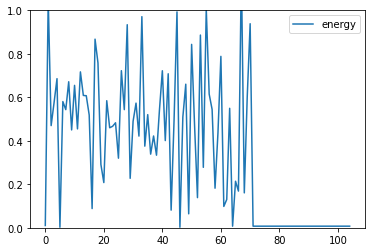

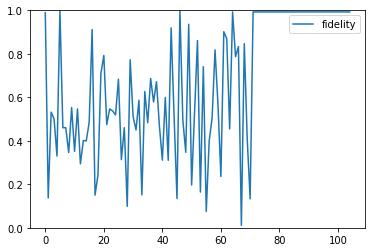

sample 6 case 3
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
 c_puct 8
move 9
move 37
move 47
move 65
movelist-end [9, 37, 47, 65, 90] fail
obs: [-0.02  0.14 -0.06 -0.1   0.  ]
movelist-end [9, 37, 47, 65, 85] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.1 ]
movelist-end [9, 37, 47, 65, 86] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.08]
movelist-end [9, 37, 47, 65, 87] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.06]
movelist-end [9, 37, 47, 65, 80] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.2 ]
movelist-end [9, 37, 47, 65, 99] fail
obs: [-0.02  0.14 -0.06 -0.1   0.18]
movelist-end [9, 37, 47, 65, 81] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.18]
movelist-end [9, 37, 47, 65, 98] fail
obs: [-0.02  0.14 -0.06 -0.1   0.16]
movelist-end [9, 37, 47, 65, 83] fail
obs: [-0.02  0.14 -0.06 -0.1  -0.14]
movelist-end [9, 37, 47, 65, 94] fail
obs: [-0.02  0.

kl:0.43677,lr_multiplier:1.000,loss:72.861572265625,entropy:1.7213795185089111
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0

movelist-end [14, 30, 56, 75, 83] fail
obs: [ 0.08  0.    0.12  0.1  -0.14]
movelist-end [14, 30, 56, 75, 85] fail
obs: [ 0.08  0.    0.12  0.1  -0.1 ]
movelist-end [14, 30, 56, 75, 98] fail
obs: [0.08 0.   0.12 0.1  0.16]
movelist-end [14, 30, 56, 75, 80] fail
obs: [ 0.08  0.    0.12  0.1  -0.2 ]
movelist-end [14, 30, 56, 75, 87] fail
obs: [ 0.08  0.    0.12  0.1  -0.06]
movelist-end [14, 30, 56, 75, 91] fail
obs: [0.08 0.   0.12 0.1  0.02]
movelist-end [14, 30, 56, 75, 94] fail
obs: [0.08 0.   0.12 0.1  0.08]
move 94
movelist-end [14, 30, 56, 75, 94] fail
obs: [0.08 0.   0.12 0.1  0.08]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:17, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 48
kl:0.80670,lr_multiplier:1.000,loss:75.2590560913086,entropy:1.8679505586624146
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
o

kl:0.03421,lr_multiplier:1.000,loss:74.49671173095703,entropy:2.0107269287109375
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: 

kl:0.04450,lr_multiplier:1.000,loss:79.70296478271484,entropy:1.5662189722061157
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: 

kl:0.03459,lr_multiplier:1.000,loss:81.47314453125,entropy:1.264084815979004
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.0

kl:0.01599,lr_multiplier:1.000,loss:80.84041595458984,entropy:1.2144290208816528
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: 

kl:0.01124,lr_multiplier:1.000,loss:80.40924072265625,entropy:1.2260715961456299
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: 

kl:0.01505,lr_multiplier:1.000,loss:80.00604248046875,entropy:1.167746901512146
 c_puct 8
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [

kl:0.00799,lr_multiplier:1.000,loss:81.5132827758789,entropy:1.0008647441864014
 c_puct 0.5
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs:

kl:0.00716,lr_multiplier:1.000,loss:81.1364517211914,entropy:1.0178526639938354
 c_puct 0.5
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs:

movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 35
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
Game end. find eigenstate: 0.005848356167854951 0.9942304086268607
winners_z [10. 10.]
batch i:17, episode_len:2
~

movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 35
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
Game end. find eigenstate: 0.005848356167854951 0.9942304086268607
winners_z [10. 10.]
batch i:23, episode_len:2
~~~~~~~~~~~~~~~~~~~~~~
train_length: 200
kl:0.00660,lr_multiplier:1.000,loss:81.56109619140625,entropy:0.951178908348

kl:0.00966,lr_multiplier:1.000,loss:81.93142700195312,entropy:0.9385935068130493
 c_puct 0.5
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
move 14
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs: [0.08 0.1  0.   0.   0.  ]
movelist-end [14, 35] win
obs

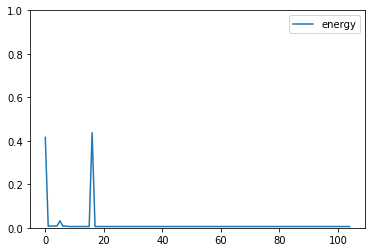

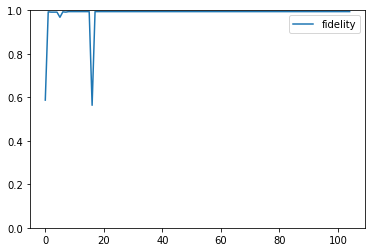

sample 6 case 4
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
 c_puct 8
move 0
move 23
move 45
move 60
movelist-end [0, 23, 45, 60, 90] fail
obs: [-0.2  -0.14 -0.1  -0.2   0.  ]
movelist-end [0, 23, 45, 60, 88] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.04]
movelist-end [0, 23, 45, 60, 95] fail
obs: [-0.2  -0.14 -0.1  -0.2   0.1 ]
movelist-end [0, 23, 45, 60, 81] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.18]
movelist-end [0, 23, 45, 60, 93] fail
obs: [-0.2  -0.14 -0.1  -0.2   0.06]
movelist-end [0, 23, 45, 60, 82] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.16]
movelist-end [0, 23, 45, 60, 83] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.14]
movelist-end [0, 23, 45, 60, 89] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.02]
movelist-end [0, 23, 45, 60, 87] fail
obs: [-0.2  -0.14 -0.1  -0.2  -0.06]
movelist-end [0, 23, 45, 60, 97] fail
obs: [-0.2  -0.

movelist-end [3, 24, 42, 61, 81] fail
obs: [-0.14 -0.12 -0.16 -0.18 -0.18]
move 91
movelist-end [3, 24, 42, 61, 91] fail
obs: [-0.14 -0.12 -0.16 -0.18  0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:8, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 20
kl:1.70997,lr_multiplier:1.000,loss:2.6598377227783203,entropy:2.3802952766418457
 c_puct 8
move 2
move 37
move 45
move 79
movelist-end [2, 37, 45, 79, 90] fail
obs: [-0.16  0.14 -0.1   0.18  0.  ]
movelist-end [2, 37, 45, 79, 88] fail
obs: [-0.16  0.14 -0.1   0.18 -0.04]
movelist-end [2, 37, 45, 79, 94] fail
obs: [-0.16  0.14 -0.1   0.18  0.08]
movelist-end [2, 37, 45, 79, 85] fail
obs: [-0.16  0.14 -0.1   0.18 -0.1 ]
movelist-end [2, 37, 45, 79, 96] fail
obs: [-0.16  0.14 -0.1   0.18  0.12]
movelist-end [2, 37, 45, 79, 80] fail
obs: [-0.16  0.14 -0.1   0.18 -0.2 ]
movelist-end [2, 37, 45, 79, 92] fail
obs: [-0.16  0.14 -0.1   0.18  0.04]
movelist-end [2, 37, 45, 79, 86] fail
obs: [-0.16  0.14 -0.1   0.18 -0.08]
movelis

movelist-end [2, 37, 42, 63, 91] fail
obs: [-0.16  0.14 -0.16 -0.14  0.02]
movelist-end [2, 37, 42, 63, 96] fail
obs: [-0.16  0.14 -0.16 -0.14  0.12]
movelist-end [2, 37, 42, 63, 86] fail
obs: [-0.16  0.14 -0.16 -0.14 -0.08]
movelist-end [2, 37, 42, 63, 94] fail
obs: [-0.16  0.14 -0.16 -0.14  0.08]
movelist-end [2, 37, 42, 63, 85] fail
obs: [-0.16  0.14 -0.16 -0.14 -0.1 ]
move 85
movelist-end [2, 37, 42, 63, 85] fail
obs: [-0.16  0.14 -0.16 -0.14 -0.1 ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:16, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 20
kl:1.16995,lr_multiplier:1.000,loss:3.161433696746826,entropy:3.199645519256592
 c_puct 8
move 11
move 33
move 45
move 78
movelist-end [11, 33, 45, 78, 90] fail
obs: [ 0.02  0.06 -0.1   0.16  0.  ]
movelist-end [11, 33, 45, 78, 80] fail
obs: [ 0.02  0.06 -0.1   0.16 -0.2 ]
movelist-end [11, 33, 45, 78, 92] fail
obs: [ 0.02  0.06 -0.1   0.16  0.04]
movelist-end [11, 33, 45, 78, 91] fail
obs: [ 0.02  0.06 -0.1   0.16  0.02]
mov

move 79
movelist-end [9, 36, 47, 79, 90] fail
obs: [-0.02  0.12 -0.06  0.18  0.  ]
movelist-end [9, 36, 47, 79, 99] fail
obs: [-0.02  0.12 -0.06  0.18  0.18]
movelist-end [9, 36, 47, 79, 94] fail
obs: [-0.02  0.12 -0.06  0.18  0.08]
movelist-end [9, 36, 47, 79, 89] fail
obs: [-0.02  0.12 -0.06  0.18 -0.02]
movelist-end [9, 36, 47, 79, 92] fail
obs: [-0.02  0.12 -0.06  0.18  0.04]
movelist-end [9, 36, 47, 79, 80] fail
obs: [-0.02  0.12 -0.06  0.18 -0.2 ]
movelist-end [9, 36, 47, 79, 91] fail
obs: [-0.02  0.12 -0.06  0.18  0.02]
movelist-end [9, 36, 47, 79, 85] fail
obs: [-0.02  0.12 -0.06  0.18 -0.1 ]
movelist-end [9, 36, 47, 79, 96] fail
obs: [-0.02  0.12 -0.06  0.18  0.12]
movelist-end [9, 36, 47, 79, 86] fail
obs: [-0.02  0.12 -0.06  0.18 -0.08]
move 86
movelist-end [9, 36, 47, 79, 86] fail
obs: [-0.02  0.12 -0.06  0.18 -0.08]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:24, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 20
kl:1.19930,lr_multiplier:1.000,loss:2.72142720

kl:0.73202,lr_multiplier:1.000,loss:18.23126220703125,entropy:2.355639696121216
 c_puct 8
move 0
move 26
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
move 45
movelist-end [0, 26, 45] win
obs: [-0.2  -0.08 -0.1   0.    0.  ]
Game end. find eigenstate: 0.009156023486683125 0.9909309648662036
winners_z [10. 10. 10.]
batch i:32, episode_len:3
~~~~~~~~~~~~~~~~~~~~~~
train_length: 26
kl:0

move 8
move 27
move 45
movelist-end [8, 27, 45, 70, 90] fail
obs: [-0.04 -0.06 -0.1   0.    0.  ]
movelist-end [8, 27, 45, 67, 90] fail
obs: [-0.04 -0.06 -0.1  -0.06  0.  ]
movelist-end [8, 27, 45, 73, 90] fail
obs: [-0.04 -0.06 -0.1   0.06  0.  ]
movelist-end [8, 27, 45, 60, 90] fail
obs: [-0.04 -0.06 -0.1  -0.2   0.  ]
movelist-end [8, 27, 45, 65, 90] fail
obs: [-0.04 -0.06 -0.1  -0.1   0.  ]
movelist-end [8, 27, 45, 69, 90] fail
obs: [-0.04 -0.06 -0.1  -0.02  0.  ]
movelist-end [8, 27, 45, 63, 90] fail
obs: [-0.04 -0.06 -0.1  -0.14  0.  ]
move 60
movelist-end [8, 27, 45, 60, 97] fail
obs: [-0.04 -0.06 -0.1  -0.2   0.14]
movelist-end [8, 27, 45, 60, 99] fail
obs: [-0.04 -0.06 -0.1  -0.2   0.18]
movelist-end [8, 27, 45, 60, 80] fail
obs: [-0.04 -0.06 -0.1  -0.2  -0.2 ]
movelist-end [8, 27, 45, 60, 91] fail
obs: [-0.04 -0.06 -0.1  -0.2   0.02]
movelist-end [8, 27, 45, 60, 92] fail
obs: [-0.04 -0.06 -0.1  -0.2   0.04]
movelist-end [8, 27, 45, 60, 88] fail
obs: [-0.04 -0.06 -0.1  -0.2  -

movelist-end [9, 23, 45, 79, 94] fail
obs: [-0.02 -0.14 -0.1   0.18  0.08]
movelist-end [9, 23, 45, 79, 81] fail
obs: [-0.02 -0.14 -0.1   0.18 -0.18]
movelist-end [9, 23, 45, 79, 97] fail
obs: [-0.02 -0.14 -0.1   0.18  0.14]
move 91
movelist-end [9, 23, 45, 79, 91] fail
obs: [-0.02 -0.14 -0.1   0.18  0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:46, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 32
kl:0.08259,lr_multiplier:1.000,loss:51.55149841308594,entropy:2.4064319133758545
 c_puct 8
move 8
move 33
move 50
move 76
movelist-end [8, 33, 50, 76, 90] fail
obs: [-0.04  0.06  0.    0.12  0.  ]
movelist-end [8, 33, 50, 76, 99] fail
obs: [-0.04  0.06  0.    0.12  0.18]
movelist-end [8, 33, 50, 76, 86] fail
obs: [-0.04  0.06  0.    0.12 -0.08]
movelist-end [8, 33, 50, 76, 96] fail
obs: [-0.04  0.06  0.    0.12  0.12]
movelist-end [8, 33, 50, 76, 80] fail
obs: [-0.04  0.06  0.    0.12 -0.2 ]
movelist-end [8, 33, 50, 76, 91] fail
obs: [-0.04  0.06  0.    0.12  0.02]
movelis

move 2
move 36
move 45
movelist-end [2, 36, 45, 70, 90] fail
obs: [-0.16  0.12 -0.1   0.    0.  ]
movelist-end [2, 36, 45, 60, 90] fail
obs: [-0.16  0.12 -0.1  -0.2   0.  ]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -0.02]
move 65
movelist-end [2, 36, 45, 65, 99] fail
obs: [-0.16  0.12 -0.1  -0.1   0.18]
movelist-end [2, 36, 45, 65, 90] fail
obs: [-0.16  0.12 -0.1  -0.1   0.  ]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -0.02]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -0.02]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -0.02]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -0.02]
movelist-end [2, 36, 45, 65, 99] fail
obs: [-0.16  0.12 -0.1  -0.1   0.18]
movelist-end [2, 36, 45, 65, 96] fail
obs: [-0.16  0.12 -0.1  -0.1   0.12]
movelist-end [2, 36, 45, 65, 90] fail
obs: [-0.16  0.12 -0.1  -0.1   0.  ]
movelist-end [2, 36, 45, 65, 89] fail
obs: [-0.16  0.12 -0.1  -0.1  -

movelist-end [9, 36, 42, 60, 88] fail
obs: [-0.02  0.12 -0.16 -0.2  -0.04]
move 96
movelist-end [9, 36, 42, 60, 96] fail
obs: [-0.02  0.12 -0.16 -0.2   0.12]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:60, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 32
kl:0.76149,lr_multiplier:1.000,loss:55.25310134887695,entropy:2.249074697494507
 c_puct 8
move 19
move 24
move 45
movelist-end [19, 24, 45, 70, 90] fail
obs: [ 0.18 -0.12 -0.1   0.    0.  ]
movelist-end [19, 24, 45, 63, 86] fail
obs: [ 0.18 -0.12 -0.1  -0.14 -0.08]
movelist-end [19, 24, 45, 60, 90] fail
obs: [ 0.18 -0.12 -0.1  -0.2   0.  ]
movelist-end [19, 24, 45, 65, 90] fail
obs: [ 0.18 -0.12 -0.1  -0.1   0.  ]
movelist-end [19, 24, 45, 73, 90] fail
obs: [ 0.18 -0.12 -0.1   0.06  0.  ]
move 63
movelist-end [19, 24, 45, 63, 96] fail
obs: [ 0.18 -0.12 -0.1  -0.14  0.12]
movelist-end [19, 24, 45, 63, 91] fail
obs: [ 0.18 -0.12 -0.1  -0.14  0.02]
movelist-end [19, 24, 45, 63, 80] fail
obs: [ 0.18 -0.12 -0.1  -0.14 -0.2 ]

kl:0.26269,lr_multiplier:1.000,loss:62.851383209228516,entropy:2.254892349243164
 c_puct 8
move 0
move 33
move 45
move 62
movelist-end [0, 33, 45, 62, 96] fail
obs: [-0.2   0.06 -0.1  -0.16  0.12]
movelist-end [0, 33, 45, 62, 80] fail
obs: [-0.2   0.06 -0.1  -0.16 -0.2 ]
movelist-end [0, 33, 45, 62, 92] fail
obs: [-0.2   0.06 -0.1  -0.16  0.04]
movelist-end [0, 33, 45, 62, 91] fail
obs: [-0.2   0.06 -0.1  -0.16  0.02]
movelist-end [0, 33, 45, 62, 86] fail
obs: [-0.2   0.06 -0.1  -0.16 -0.08]
movelist-end [0, 33, 45, 62, 94] fail
obs: [-0.2   0.06 -0.1  -0.16  0.08]
movelist-end [0, 33, 45, 62, 90] fail
obs: [-0.2   0.06 -0.1  -0.16  0.  ]
movelist-end [0, 33, 45, 62, 88] fail
obs: [-0.2   0.06 -0.1  -0.16 -0.04]
movelist-end [0, 33, 45, 62, 99] fail
obs: [-0.2   0.06 -0.1  -0.16  0.18]
movelist-end [0, 33, 45, 62, 98] fail
obs: [-0.2   0.06 -0.1  -0.16  0.16]
move 94
movelist-end [0, 33, 45, 62, 94] fail
obs: [-0.2   0.06 -0.1  -0.16  0.08]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.

movelist-end [3, 20, 47, 60, 88] fail
obs: [-0.14 -0.2  -0.06 -0.2  -0.04]
movelist-end [3, 20, 47, 60, 98] fail
obs: [-0.14 -0.2  -0.06 -0.2   0.16]
move 97
movelist-end [3, 20, 47, 60, 97] fail
obs: [-0.14 -0.2  -0.06 -0.2   0.14]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:5, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 38
kl:0.20378,lr_multiplier:1.000,loss:65.79398345947266,entropy:2.081691265106201
 c_puct 0.5
move 3
move 20
move 42
movelist-end [3, 20, 42, 65] win
obs: [-0.14 -0.2  -0.16 -0.1   0.  ]
movelist-end [3, 20, 42, 65] win
obs: [-0.14 -0.2  -0.16 -0.1   0.  ]
movelist-end [3, 20, 42, 65] win
obs: [-0.14 -0.2  -0.16 -0.1   0.  ]
movelist-end [3, 20, 42, 65] win
obs: [-0.14 -0.2  -0.16 -0.1   0.  ]
move 65
movelist-end [3, 20, 42, 65] win
obs: [-0.14 -0.2  -0.16 -0.1   0.  ]
Game end. find eigenstate: 0.006239767317013317 0.9939105850371402
winners_z [10. 10. 10. 10.]
batch i:6, episode_len:4
~~~~~~~~~~~~~~~~~~~~~~
train_length: 42
kl:0.38176,lr_multipli

movelist-end [0, 20, 57, 67, 81] fail
obs: [-0.2  -0.2   0.14 -0.06 -0.18]
move 80
movelist-end [0, 20, 57, 67, 80] fail
obs: [-0.2  -0.2   0.14 -0.06 -0.2 ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:13, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 42
kl:0.09040,lr_multiplier:1.000,loss:69.93171691894531,entropy:3.5877845287323
 c_puct 0.5
move 11
move 31
move 57
move 63
movelist-end [11, 31, 57, 63, 90] fail
obs: [ 0.02  0.02  0.14 -0.14  0.  ]
movelist-end [11, 31, 57, 63, 86] fail
obs: [ 0.02  0.02  0.14 -0.14 -0.08]
movelist-end [11, 31, 57, 63, 91] fail
obs: [ 0.02  0.02  0.14 -0.14  0.02]
movelist-end [11, 31, 57, 63, 96] fail
obs: [ 0.02  0.02  0.14 -0.14  0.12]
movelist-end [11, 31, 57, 63, 92] fail
obs: [ 0.02  0.02  0.14 -0.14  0.04]
movelist-end [11, 31, 57, 63, 80] fail
obs: [ 0.02  0.02  0.14 -0.14 -0.2 ]
movelist-end [11, 31, 57, 63, 88] fail
obs: [ 0.02  0.02  0.14 -0.14 -0.04]
movelist-end [11, 31, 57, 63, 94] fail
obs: [ 0.02  0.02  0.14 -0.14  0.08]

movelist-end [10, 27, 45, 79, 91] fail
obs: [ 0.   -0.06 -0.1   0.18  0.02]
movelist-end [10, 27, 45, 79, 86] fail
obs: [ 0.   -0.06 -0.1   0.18 -0.08]
movelist-end [10, 27, 45, 79, 98] fail
obs: [ 0.   -0.06 -0.1   0.18  0.16]
movelist-end [10, 27, 45, 79, 94] fail
obs: [ 0.   -0.06 -0.1   0.18  0.08]
movelist-end [10, 27, 45, 79, 88] fail
obs: [ 0.   -0.06 -0.1   0.18 -0.04]
move 94
movelist-end [10, 27, 45, 79, 94] fail
obs: [ 0.   -0.06 -0.1   0.18  0.08]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:21, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 42
kl:0.23837,lr_multiplier:1.000,loss:66.86201477050781,entropy:3.431060314178467
 c_puct 0.5
move 5
move 30
movelist-end [5, 30, 47] win
obs: [-0.1   0.   -0.06  0.    0.  ]
movelist-end [5, 30, 47] win
obs: [-0.1   0.   -0.06  0.    0.  ]
movelist-end [5, 30, 47] win
obs: [-0.1   0.   -0.06  0.    0.  ]
movelist-end [5, 30, 47] win
obs: [-0.1   0.   -0.06  0.    0.  ]
movelist-end [5, 30, 47] win
obs: [-0.1   0.   -0.06

movelist-end [3, 37, 47, 61, 96] fail
obs: [-0.14  0.14 -0.06 -0.18  0.12]
movelist-end [3, 37, 47, 61, 92] fail
obs: [-0.14  0.14 -0.06 -0.18  0.04]
movelist-end [3, 37, 47, 61, 97] fail
obs: [-0.14  0.14 -0.06 -0.18  0.14]
movelist-end [3, 37, 47, 61, 91] fail
obs: [-0.14  0.14 -0.06 -0.18  0.02]
movelist-end [3, 37, 47, 61, 81] fail
obs: [-0.14  0.14 -0.06 -0.18 -0.18]
movelist-end [3, 37, 47, 61, 88] fail
obs: [-0.14  0.14 -0.06 -0.18 -0.04]
movelist-end [3, 37, 47, 61, 80] fail
obs: [-0.14  0.14 -0.06 -0.18 -0.2 ]
move 90
movelist-end [3, 37, 47, 61, 90] fail
obs: [-0.14  0.14 -0.06 -0.18  0.  ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:29, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 45
kl:0.16397,lr_multiplier:1.000,loss:76.15880584716797,entropy:3.525049924850464
 c_puct 0.5
move 19
move 31
move 57
move 61
movelist-end [19, 31, 57, 61, 90] fail
obs: [ 0.18  0.02  0.14 -0.18  0.  ]
movelist-end [19, 31, 57, 61, 80] fail
obs: [ 0.18  0.02  0.14 -0.18 -0.2 ]
mov

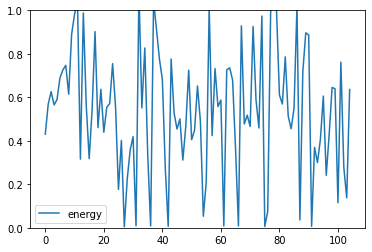

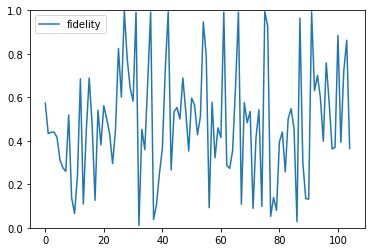

sample 6 case 5
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
 c_puct 8
move 16
move 23
move 48
move 66
movelist-end [16, 23, 48, 66, 90] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.  ]
movelist-end [16, 23, 48, 66, 87] fail
obs: [ 0.12 -0.14 -0.04 -0.08 -0.06]
movelist-end [16, 23, 48, 66, 81] fail
obs: [ 0.12 -0.14 -0.04 -0.08 -0.18]
movelist-end [16, 23, 48, 66, 99] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.18]
movelist-end [16, 23, 48, 66, 98] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.16]
movelist-end [16, 23, 48, 66, 84] fail
obs: [ 0.12 -0.14 -0.04 -0.08 -0.12]
movelist-end [16, 23, 48, 66, 96] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.12]
movelist-end [16, 23, 48, 66, 93] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.06]
movelist-end [16, 23, 48, 66, 95] fail
obs: [ 0.12 -0.14 -0.04 -0.08  0.1 ]
movelist-end [16, 23, 48, 66, 83] fail
obs:

movelist-end [10, 26, 54, 74, 95] fail
obs: [ 0.   -0.08  0.08  0.08  0.1 ]
movelist-end [10, 26, 54, 74, 92] fail
obs: [ 0.   -0.08  0.08  0.08  0.04]
movelist-end [10, 26, 54, 74, 97] fail
obs: [ 0.   -0.08  0.08  0.08  0.14]
move 90
movelist-end [10, 26, 54, 74, 90] fail
obs: [ 0.   -0.08  0.08  0.08  0.  ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:7, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 22
kl:3.44045,lr_multiplier:1.000,loss:20.430912017822266,entropy:2.102818012237549
 c_puct 8
move 19
move 29
movelist-end [19, 29, 50, 70, 80] fail
obs: [ 0.18 -0.02  0.    0.   -0.2 ]
movelist-end [19, 29, 50, 70, 86] fail
obs: [ 0.18 -0.02  0.    0.   -0.08]
movelist-end [19, 29, 50, 72, 90] fail
obs: [ 0.18 -0.02  0.    0.04  0.  ]
movelist-end [19, 29, 50, 67, 90] fail
obs: [ 0.18 -0.02  0.   -0.06  0.  ]
movelist-end [19, 29, 50, 78, 90] fail
obs: [ 0.18 -0.02  0.    0.16  0.  ]
movelist-end [19, 29, 50, 65, 90] fail
obs: [ 0.18 -0.02  0.   -0.1   0.  ]
move 50
movel

movelist-end [10, 30, 50, 66, 90] fail
obs: [ 0.    0.    0.   -0.08  0.  ]
move 10
movelist-end [10, 30, 50, 60, 90] fail
obs: [ 0.   0.   0.  -0.2  0. ]
movelist-end [10, 30, 50, 70, 90] fail
obs: [0. 0. 0. 0. 0.]
movelist-end [10, 30, 50, 66, 96] fail
obs: [ 0.    0.    0.   -0.08  0.12]
movelist-end [10, 30, 50, 71, 81] fail
obs: [ 0.    0.    0.    0.02 -0.18]
movelist-end [10, 30, 50, 75, 90] fail
obs: [0.  0.  0.  0.1 0. ]
movelist-end [10, 30, 50, 72, 96] fail
obs: [0.   0.   0.   0.04 0.12]
move 30
movelist-end [10, 30, 50, 74, 96] fail
obs: [0.   0.   0.   0.08 0.12]
movelist-end [10, 30, 50, 66, 95] fail
obs: [ 0.    0.    0.   -0.08  0.1 ]
movelist-end [10, 30, 50, 64, 90] fail
obs: [ 0.    0.    0.   -0.12  0.  ]
movelist-end [10, 30, 50, 60, 81] fail
obs: [ 0.    0.    0.   -0.2  -0.18]
movelist-end [10, 30, 58, 70, 81] fail
obs: [ 0.    0.    0.16  0.   -0.18]
move 50
movelist-end [10, 30, 50, 70, 96] fail
obs: [0.   0.   0.   0.   0.12]
movelist-end [10, 30, 50, 77, 90]

movelist-end [10, 33, 45, 70, 84] fail
obs: [ 0.    0.06 -0.1   0.   -0.12]
movelist-end [10, 33, 45, 70, 80] fail
obs: [ 0.    0.06 -0.1   0.   -0.2 ]
movelist-end [10, 33, 45, 70, 97] fail
obs: [ 0.    0.06 -0.1   0.    0.14]
movelist-end [10, 33, 45, 70, 96] fail
obs: [ 0.    0.06 -0.1   0.    0.12]
move 88
movelist-end [10, 33, 45, 70, 88] fail
obs: [ 0.    0.06 -0.1   0.   -0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:15, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 22
kl:1.19307,lr_multiplier:1.000,loss:16.472522735595703,entropy:1.8857134580612183
 c_puct 8
move 19
movelist-end [19, 35, 50, 77, 92] fail
obs: [0.18 0.1  0.   0.14 0.04]
movelist-end [19, 29, 50, 70, 97] fail
obs: [ 0.18 -0.02  0.    0.    0.14]
move 35
movelist-end [19, 35, 50, 72, 90] fail
obs: [0.18 0.1  0.   0.04 0.  ]
movelist-end [19, 35, 50, 64, 90] fail
obs: [ 0.18  0.1   0.   -0.12  0.  ]
movelist-end [19, 35, 50, 70, 97] fail
obs: [0.18 0.1  0.   0.   0.14]
movelist-end [19, 35, 50, 

movelist-end [10, 26, 53, 70, 99] fail
obs: [ 0.   -0.08  0.06  0.    0.18]
movelist-end [10, 26, 53, 70, 98] fail
obs: [ 0.   -0.08  0.06  0.    0.16]
movelist-end [10, 26, 53, 70, 81] fail
obs: [ 0.   -0.08  0.06  0.   -0.18]
movelist-end [10, 26, 53, 70, 87] fail
obs: [ 0.   -0.08  0.06  0.   -0.06]
movelist-end [10, 26, 53, 70, 83] fail
obs: [ 0.   -0.08  0.06  0.   -0.14]
movelist-end [10, 26, 53, 70, 97] fail
obs: [ 0.   -0.08  0.06  0.    0.14]
movelist-end [10, 26, 53, 70, 84] fail
obs: [ 0.   -0.08  0.06  0.   -0.12]
movelist-end [10, 26, 53, 70, 95] fail
obs: [ 0.   -0.08  0.06  0.    0.1 ]
move 87
movelist-end [10, 26, 53, 70, 87] fail
obs: [ 0.   -0.08  0.06  0.   -0.06]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:19, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 22
kl:1.41953,lr_multiplier:1.000,loss:13.262401580810547,entropy:2.152693271636963
 c_puct 8
move 10
movelist-end [10, 33, 50, 74, 81] fail
obs: [ 0.    0.06  0.    0.08 -0.18]
move 24
movelist-end

move 10
movelist-end [10, 25, 50, 77, 90] fail
obs: [ 0.   -0.1   0.    0.14  0.  ]
move 25
movelist-end [10, 25, 50, 72, 90] fail
obs: [ 0.   -0.1   0.    0.04  0.  ]
movelist-end [10, 25, 50, 70, 90] fail
obs: [ 0.  -0.1  0.   0.   0. ]
movelist-end [10, 25, 50, 74, 86] fail
obs: [ 0.   -0.1   0.    0.08 -0.08]
movelist-end [10, 25, 50, 66, 90] fail
obs: [ 0.   -0.1   0.   -0.08  0.  ]
movelist-end [10, 25, 50, 71, 90] fail
obs: [ 0.   -0.1   0.    0.02  0.  ]
move 50
movelist-end [10, 25, 50, 60, 90] fail
obs: [ 0.  -0.1  0.  -0.2  0. ]
movelist-end [10, 25, 50, 77, 84] fail
obs: [ 0.   -0.1   0.    0.14 -0.12]
movelist-end [10, 25, 50, 72, 84] fail
obs: [ 0.   -0.1   0.    0.04 -0.12]
movelist-end [10, 25, 50, 61, 88] fail
obs: [ 0.   -0.1   0.   -0.18 -0.04]
movelist-end [10, 25, 50, 70, 84] fail
obs: [ 0.   -0.1   0.    0.   -0.12]
movelist-end [10, 25, 50, 69, 88] fail
obs: [ 0.   -0.1   0.   -0.02 -0.04]
move 69
movelist-end [10, 25, 50, 69, 82] fail
obs: [ 0.   -0.1   0.   -0.

movelist-end [10, 30, 50, 66, 87] fail
obs: [ 0.    0.    0.   -0.08 -0.06]
movelist-end [10, 30, 50, 66, 81] fail
obs: [ 0.    0.    0.   -0.08 -0.18]
move 81
movelist-end [10, 30, 50, 66, 81] fail
obs: [ 0.    0.    0.   -0.08 -0.18]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:29, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:1.83287,lr_multiplier:1.000,loss:32.4845085144043,entropy:2.2128944396972656
 c_puct 8
move 10
move 26
move 45
movelist-end [10, 26, 45, 70, 81] fail
obs: [ 0.   -0.08 -0.1   0.   -0.18]
movelist-end [10, 26, 45, 70, 90] fail
obs: [ 0.   -0.08 -0.1   0.    0.  ]
movelist-end [10, 26, 45, 64, 90] fail
obs: [ 0.   -0.08 -0.1  -0.12  0.  ]
move 70
movelist-end [10, 26, 45, 70, 98] fail
obs: [ 0.   -0.08 -0.1   0.    0.16]
movelist-end [10, 26, 45, 70, 87] fail
obs: [ 0.   -0.08 -0.1   0.   -0.06]
movelist-end [10, 26, 45, 70, 93] fail
obs: [ 0.   -0.08 -0.1   0.    0.06]
movelist-end [10, 26, 45, 70, 96] fail
obs: [ 0.   -0.08 -0.1   0.    0.1

move 50
movelist-end [0, 30, 50, 70, 84] fail
obs: [-0.2   0.    0.    0.   -0.12]
move 60
movelist-end [0, 30, 50, 60, 90] fail
obs: [-0.2  0.   0.  -0.2  0. ]
movelist-end [0, 30, 50, 60, 84] fail
obs: [-0.2   0.    0.   -0.2  -0.12]
movelist-end [0, 30, 50, 60, 97] fail
obs: [-0.2   0.    0.   -0.2   0.14]
movelist-end [0, 30, 50, 60, 86] fail
obs: [-0.2   0.    0.   -0.2  -0.08]
movelist-end [0, 30, 50, 60, 88] fail
obs: [-0.2   0.    0.   -0.2  -0.04]
movelist-end [0, 30, 50, 60, 82] fail
obs: [-0.2   0.    0.   -0.2  -0.16]
movelist-end [0, 30, 50, 60, 89] fail
obs: [-0.2   0.    0.   -0.2  -0.02]
movelist-end [0, 30, 50, 60, 94] fail
obs: [-0.2   0.    0.   -0.2   0.08]
movelist-end [0, 30, 50, 60, 91] fail
obs: [-0.2   0.    0.   -0.2   0.02]
movelist-end [0, 30, 50, 60, 80] fail
obs: [-0.2  0.   0.  -0.2 -0.2]
move 86
movelist-end [0, 30, 50, 60, 86] fail
obs: [-0.2   0.    0.   -0.2  -0.08]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:36, episode_len:5
~~~~~~~~~~~~~

movelist-end [19, 26, 50, 64, 85] fail
obs: [ 0.18 -0.08  0.   -0.12 -0.1 ]
movelist-end [19, 26, 50, 64, 84] fail
obs: [ 0.18 -0.08  0.   -0.12 -0.12]
movelist-end [19, 26, 50, 64, 86] fail
obs: [ 0.18 -0.08  0.   -0.12 -0.08]
move 82
movelist-end [19, 26, 50, 64, 82] fail
obs: [ 0.18 -0.08  0.   -0.12 -0.16]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:42, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 31
kl:0.46374,lr_multiplier:1.000,loss:44.805545806884766,entropy:1.924960970878601
 c_puct 8
move 10
move 26
move 51
move 73
movelist-end [10, 26, 51, 73, 90] fail
obs: [ 0.   -0.08  0.02  0.06  0.  ]
movelist-end [10, 26, 51, 73, 91] fail
obs: [ 0.   -0.08  0.02  0.06  0.02]
movelist-end [10, 26, 51, 73, 94] fail
obs: [ 0.   -0.08  0.02  0.06  0.08]
movelist-end [10, 26, 51, 73, 89] fail
obs: [ 0.   -0.08  0.02  0.06 -0.02]
movelist-end [10, 26, 51, 73, 82] fail
obs: [ 0.   -0.08  0.02  0.06 -0.16]
movelist-end [10, 26, 51, 73, 88] fail
obs: [ 0.   -0.08  0.02  0.06 -0.

kl:0.98904,lr_multiplier:1.000,loss:47.328060150146484,entropy:1.666524887084961
 c_puct 8
move 10
movelist-end [10, 33, 50, 70, 87] fail
obs: [ 0.    0.06  0.    0.   -0.06]
movelist-end [10, 26, 50, 70, 87] fail
obs: [ 0.   -0.08  0.    0.   -0.06]
move 26
movelist-end [10, 26, 50, 77, 98] fail
obs: [ 0.   -0.08  0.    0.14  0.16]
movelist-end [10, 26, 50, 64, 90] fail
obs: [ 0.   -0.08  0.   -0.12  0.  ]
movelist-end [10, 26, 50, 72, 98] fail
obs: [ 0.   -0.08  0.    0.04  0.16]
movelist-end [10, 26, 50, 74, 90] fail
obs: [ 0.   -0.08  0.    0.08  0.  ]
movelist-end [10, 26, 50, 66, 87] fail
obs: [ 0.   -0.08  0.   -0.08 -0.06]
move 50
movelist-end [10, 26, 50, 71, 90] fail
obs: [ 0.   -0.08  0.    0.02  0.  ]
movelist-end [10, 26, 50, 70, 98] fail
obs: [ 0.   -0.08  0.    0.    0.16]
movelist-end [10, 26, 50, 73, 90] fail
obs: [ 0.   -0.08  0.    0.06  0.  ]
movelist-end [10, 26, 50, 77, 87] fail
obs: [ 0.   -0.08  0.    0.14 -0.06]
movelist-end [10, 26, 50, 61, 90] fail
obs: [ 0. 

movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 50
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
mo

kl:0.15469,lr_multiplier:1.000,loss:58.50682067871094,entropy:1.5117067098617554
 c_puct 8
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0. 

movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 71
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
Game end. find eigenstate: 0.0031943799468407553 0.9969304572383264
winners_z [10. 10. 10. 10.]
batch i:62, episode_len:4
~~~~~~~~~~~~~~~~~~~~~~
train_length: 77
kl:0.30181,lr_multiplier:1.000,loss:65.03121948242188,entropy:1.0632426738739014
 c_puct 8
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movel

movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 35
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 50
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 

movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 71
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
Game end. find eigenstate: 0.0031943799468407553 0.9969304572383264
winners_z [10. 10. 10. 10.]
batch i:69, episode_len:4
~~~~~~~~~~~~~~~~~~~~~~
train_length: 105
kl:0.02772,lr_multiplier:1.000,loss:72.27256774902344,entropy:0.7877101898193359
 c_puct 8
movelist-end

movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 71
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
Game end. find eigenstate: 0.0031943799468407553 0.9969304572383264
winners_z [10. 10. 10. 10.]
batch i:2, episode_len:4
~~~~~~~~~~~~~~~~~~~~~~
train_length: 117
kl:0.09929,lr_multiplier:1.000,loss:71.9674301147461,entropy:0.7847298383712769
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move

kl:0.03205,lr_multiplier:1.000,loss:74.57434844970703,entropy:0.7156354188919067
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0

kl:0.10005,lr_multiplier:1.000,loss:73.70343780517578,entropy:0.676497757434845
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.

kl:0.05858,lr_multiplier:1.000,loss:76.34252166748047,entropy:0.5943329334259033
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0

kl:0.03670,lr_multiplier:1.000,loss:76.77059936523438,entropy:0.5256676077842712
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0

kl:0.09217,lr_multiplier:1.000,loss:77.04825592041016,entropy:0.4585750699043274
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0

kl:0.09274,lr_multiplier:1.000,loss:76.59635162353516,entropy:0.4071666896343231
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0

kl:0.17569,lr_multiplier:1.000,loss:76.57405090332031,entropy:0.38053223490715027
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [

kl:0.16680,lr_multiplier:1.000,loss:78.6923828125,entropy:0.3220197558403015
 c_puct 0.5
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
move 10
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   0.1  0.   0.02 0.  ]
movelist-end [10, 35, 50, 71] win
obs: [0.   

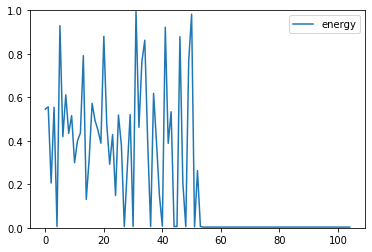

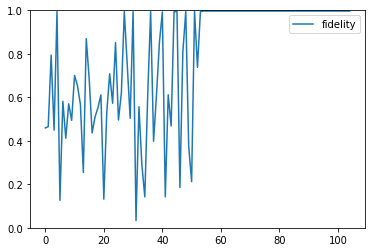

sample 6 case 6
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
 c_puct 8
movelist-end [10, 30, 50, 70, 90] fail
obs: [0. 0. 0. 0. 0.]
move 10
movelist-end [10, 32, 50, 70, 90] fail
obs: [0.   0.04 0.   0.   0.  ]
move 35
movelist-end [10, 35, 50, 70, 90] fail
obs: [0.  0.1 0.  0.  0. ]
movelist-end [10, 35, 46, 70, 90] fail
obs: [ 0.    0.1  -0.08  0.    0.  ]
movelist-end [10, 35, 55, 70, 90] fail
obs: [0.  0.1 0.1 0.  0. ]
move 50
movelist-end [10, 35, 50, 72, 90] fail
obs: [0.   0.1  0.   0.04 0.  ]
movelist-end [10, 35, 50, 63, 90] fail
obs: [ 0.    0.1   0.   -0.14  0.  ]
movelist-end [10, 35, 50, 66, 90] fail
obs: [ 0.    0.1   0.   -0.08  0.  ]
movelist-end [10, 35, 50, 78, 90] fail
obs: [0.   0.1  0.   0.16 0.  ]
movelist-end [10, 35, 50, 65, 90] fail
obs: [ 0.   0.1  0.  -0.1  0. ]
move 70
movelist-end [10, 35, 

movelist-end [10, 25, 50, 66, 98] fail
obs: [ 0.   -0.1   0.   -0.08  0.16]
movelist-end [10, 25, 50, 66, 95] fail
obs: [ 0.   -0.1   0.   -0.08  0.1 ]
movelist-end [10, 25, 50, 66, 87] fail
obs: [ 0.   -0.1   0.   -0.08 -0.06]
movelist-end [10, 25, 50, 66, 85] fail
obs: [ 0.   -0.1   0.   -0.08 -0.1 ]
movelist-end [10, 25, 50, 66, 93] fail
obs: [ 0.   -0.1   0.   -0.08  0.06]
move 81
movelist-end [10, 25, 50, 66, 81] fail
obs: [ 0.   -0.1   0.   -0.08 -0.18]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:5, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 20
kl:5.72109,lr_multiplier:1.000,loss:3.130910873413086,entropy:2.615767002105713
 c_puct 8
move 9
move 32
move 46
move 76
movelist-end [9, 32, 46, 76, 90] fail
obs: [-0.02  0.04 -0.08  0.12  0.  ]
movelist-end [9, 32, 46, 76, 85] fail
obs: [-0.02  0.04 -0.08  0.12 -0.1 ]
movelist-end [9, 32, 46, 76, 98] fail
obs: [-0.02  0.04 -0.08  0.12  0.16]
movelist-end [9, 32, 46, 76, 89] fail
obs: [-0.02  0.04 -0.08  0.12 -0.02]
mov

kl:0.23723,lr_multiplier:1.000,loss:43.73221206665039,entropy:1.7716509103775024
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

kl:0.14477,lr_multiplier:1.000,loss:73.69188690185547,entropy:1.0167688131332397
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

kl:0.15529,lr_multiplier:1.000,loss:69.21147155761719,entropy:0.553855299949646
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [

kl:0.05228,lr_multiplier:1.000,loss:71.82015991210938,entropy:0.4133473038673401
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

kl:0.10447,lr_multiplier:1.000,loss:72.6872787475586,entropy:0.41408270597457886
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

kl:0.06428,lr_multiplier:1.000,loss:73.8309555053711,entropy:0.36933454871177673
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 34
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
Game end. find eigenstate: 0.00975391428126564 0.9903251798855612
winners_z [10. 10.]
batch i:60, episode_len:2
~~~~~~~~~~~~~~~~~~~~~~
train_length: 118
kl:0.07629,lr_multiplier:1.000,loss:77.32180786132812,entropy:0.2222224622964859
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.

kl:0.05825,lr_multiplier:1.000,loss:77.11061096191406,entropy:0.1852465122938156
 c_puct 8
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: 

movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 34
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
Game end. find eigenstate: 0.00975391428126564 0.9903251798855612
winners_z [10. 10.]
batch i:5, episode_len:2
~~~~~~~~~~~~~~~~~~~~~~
train_length: 148
kl:0.08075,lr_multiplier:1.000,loss:78.86302185058594,entropy:0.9616785645484924
 c_puct 0.5
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0

kl:0.02074,lr_multiplier:1.000,loss:79.1292953491211,entropy:0.9574965238571167
 c_puct 0.5
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs:

kl:0.03192,lr_multiplier:1.000,loss:80.5928955078125,entropy:0.8898084759712219
 c_puct 0.5
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs:

movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 34
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
Game end. find eigenstate: 0.00975391428126564 0.9903251798855612
winners_z [10. 10.]
batch i:26, episode_len:2
~~~~~~~~~~~~~~~~~~~~~~
train_length: 190
kl:0.01868,lr_multiplier:1.000,loss:80.27381134033203,entropy:0.8780434131622314
 c_puct 0.5
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 

kl:0.02628,lr_multiplier:1.000,loss:79.64334869384766,entropy:0.9177094101905823
 c_puct 0.5
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
move 12
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs: [0.04 0.08 0.   0.   0.  ]
movelist-end [12, 34] win
obs

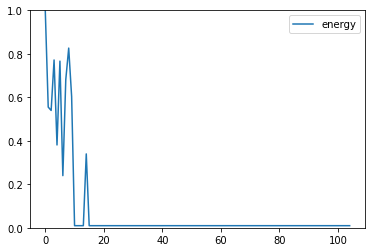

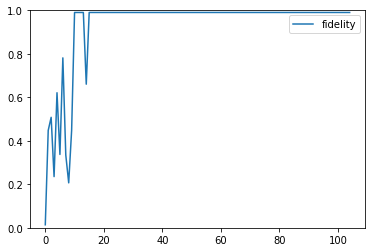

sample 6 case 7
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
 c_puct 8
move 4
move 23
move 40
movelist-end [4, 23, 40, 70, 96] fail
obs: [-0.12 -0.14 -0.2   0.    0.12]
movelist-end [4, 23, 40, 68, 96] fail
obs: [-0.12 -0.14 -0.2  -0.04  0.12]
move 68
movelist-end [4, 23, 40, 68, 91] fail
obs: [-0.12 -0.14 -0.2  -0.04  0.02]
movelist-end [4, 23, 40, 68, 85] fail
obs: [-0.12 -0.14 -0.2  -0.04 -0.1 ]
movelist-end [4, 23, 40, 68, 88] fail
obs: [-0.12 -0.14 -0.2  -0.04 -0.04]
movelist-end [4, 23, 40, 68, 97] fail
obs: [-0.12 -0.14 -0.2  -0.04  0.14]
movelist-end [4, 23, 40, 68, 98] fail
obs: [-0.12 -0.14 -0.2  -0.04  0.16]
movelist-end [4, 23, 40, 68, 99] fail
obs: [-0.12 -0.14 -0.2  -0.04  0.18]
movelist-end [4, 23, 40, 68, 89] fail
obs: [-0.12 -0.14 -0.2  -0.04 -0.02]
movelist-end [4, 23, 40, 68, 84] fail
obs: [-0.12 -0.

movelist-end [7, 23, 57, 78, 99] fail
obs: [-0.06 -0.14  0.14  0.16  0.18]
movelist-end [7, 23, 57, 78, 92] fail
obs: [-0.06 -0.14  0.14  0.16  0.04]
movelist-end [7, 23, 57, 78, 91] fail
obs: [-0.06 -0.14  0.14  0.16  0.02]
move 92
movelist-end [7, 23, 57, 78, 92] fail
obs: [-0.06 -0.14  0.14  0.16  0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:8, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 20
kl:0.13593,lr_multiplier:1.000,loss:4.220644950866699,entropy:3.902369976043701
 c_puct 8
move 19
move 36
move 57
move 66
movelist-end [19, 36, 57, 66, 91] fail
obs: [ 0.18  0.12  0.14 -0.08  0.02]
movelist-end [19, 36, 57, 66, 88] fail
obs: [ 0.18  0.12  0.14 -0.08 -0.04]
movelist-end [19, 36, 57, 66, 92] fail
obs: [ 0.18  0.12  0.14 -0.08  0.04]
movelist-end [19, 36, 57, 66, 85] fail
obs: [ 0.18  0.12  0.14 -0.08 -0.1 ]
movelist-end [19, 36, 57, 66, 97] fail
obs: [ 0.18  0.12  0.14 -0.08  0.14]
movelist-end [19, 36, 57, 66, 99] fail
obs: [ 0.18  0.12  0.14 -0.08  0.18]
mo

movelist-end [8, 28, 57, 78, 88] fail
obs: [-0.04 -0.04  0.14  0.16 -0.04]
movelist-end [8, 28, 57, 78, 89] fail
obs: [-0.04 -0.04  0.14  0.16 -0.02]
movelist-end [8, 28, 57, 78, 85] fail
obs: [-0.04 -0.04  0.14  0.16 -0.1 ]
movelist-end [8, 28, 57, 78, 97] fail
obs: [-0.04 -0.04  0.14  0.16  0.14]
movelist-end [8, 28, 57, 78, 84] fail
obs: [-0.04 -0.04  0.14  0.16 -0.12]
movelist-end [8, 28, 57, 78, 96] fail
obs: [-0.04 -0.04  0.14  0.16  0.12]
movelist-end [8, 28, 57, 78, 99] fail
obs: [-0.04 -0.04  0.14  0.16  0.18]
move 84
movelist-end [8, 28, 57, 78, 84] fail
obs: [-0.04 -0.04  0.14  0.16 -0.12]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:16, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:0.23484,lr_multiplier:1.000,loss:24.1553955078125,entropy:3.860541343688965
 c_puct 8
move 7
move 24
move 51
move 71
movelist-end [7, 24, 51, 71, 90] fail
obs: [-0.06 -0.12  0.02  0.02  0.  ]
movelist-end [7, 24, 51, 71, 88] fail
obs: [-0.06 -0.12  0.02  0.02 -0.04]
movelist-

movelist-end [4, 30, 46, 71, 84] fail
obs: [-0.12  0.   -0.08  0.02 -0.12]
movelist-end [4, 30, 46, 71, 99] fail
obs: [-0.12  0.   -0.08  0.02  0.18]
movelist-end [4, 30, 46, 71, 92] fail
obs: [-0.12  0.   -0.08  0.02  0.04]
movelist-end [4, 30, 46, 71, 91] fail
obs: [-0.12  0.   -0.08  0.02  0.02]
movelist-end [4, 30, 46, 71, 90] fail
obs: [-0.12  0.   -0.08  0.02  0.  ]
movelist-end [4, 30, 46, 71, 98] fail
obs: [-0.12  0.   -0.08  0.02  0.16]
move 89
movelist-end [4, 30, 46, 71, 89] fail
obs: [-0.12  0.   -0.08  0.02 -0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:23, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 28
kl:0.19430,lr_multiplier:1.000,loss:51.4112548828125,entropy:3.8014473915100098
 c_puct 8
move 18
move 30
move 51
move 74
movelist-end [18, 30, 51, 74, 90] fail
obs: [0.16 0.   0.02 0.08 0.  ]
movelist-end [18, 30, 51, 74, 85] fail
obs: [ 0.16  0.    0.02  0.08 -0.1 ]
movelist-end [18, 30, 51, 74, 89] fail
obs: [ 0.16  0.    0.02  0.08 -0.02]
movelist-

movelist-end [10, 34, 46, 71, 90] fail
obs: [ 0.    0.08 -0.08  0.02  0.  ]
movelist-end [10, 34, 51, 71, 90] fail
obs: [0.   0.08 0.02 0.02 0.  ]
move 47
movelist-end [10, 34, 47, 71, 92] fail
obs: [ 0.    0.08 -0.06  0.02  0.04]
movelist-end [10, 34, 47, 74, 90] fail
obs: [ 0.    0.08 -0.06  0.08  0.  ]
movelist-end [10, 34, 47, 70, 90] fail
obs: [ 0.    0.08 -0.06  0.    0.  ]
movelist-end [10, 34, 47, 64, 90] fail
obs: [ 0.    0.08 -0.06 -0.12  0.  ]
movelist-end [10, 34, 47, 60, 90] fail
obs: [ 0.    0.08 -0.06 -0.2   0.  ]
move 70
movelist-end [10, 34, 47, 70, 92] fail
obs: [ 0.    0.08 -0.06  0.    0.04]
movelist-end [10, 34, 47, 70, 99] fail
obs: [ 0.    0.08 -0.06  0.    0.18]
movelist-end [10, 34, 47, 70, 84] fail
obs: [ 0.    0.08 -0.06  0.   -0.12]
movelist-end [10, 34, 47, 70, 91] fail
obs: [ 0.    0.08 -0.06  0.    0.02]
movelist-end [10, 34, 47, 70, 96] fail
obs: [ 0.    0.08 -0.06  0.    0.12]
movelist-end [10, 34, 47, 70, 97] fail
obs: [ 0.    0.08 -0.06  0.    0.14]
m

movelist-end [10, 36, 54, 71, 90] fail
obs: [0.   0.12 0.08 0.02 0.  ]
movelist-end [10, 36, 47, 71, 90] fail
obs: [ 0.    0.12 -0.06  0.02  0.  ]
move 50
movelist-end [10, 36, 50, 71, 91] fail
obs: [0.   0.12 0.   0.02 0.02]
movelist-end [10, 36, 50, 70, 90] fail
obs: [0.   0.12 0.   0.   0.  ]
movelist-end [10, 36, 50, 64, 90] fail
obs: [ 0.    0.12  0.   -0.12  0.  ]
movelist-end [10, 36, 50, 68, 90] fail
obs: [ 0.    0.12  0.   -0.04  0.  ]
movelist-end [10, 36, 50, 60, 90] fail
obs: [ 0.    0.12  0.   -0.2   0.  ]
move 64
movelist-end [10, 36, 50, 64, 91] fail
obs: [ 0.    0.12  0.   -0.12  0.02]
movelist-end [10, 36, 50, 64, 92] fail
obs: [ 0.    0.12  0.   -0.12  0.04]
movelist-end [10, 36, 50, 64, 85] fail
obs: [ 0.    0.12  0.   -0.12 -0.1 ]
movelist-end [10, 36, 50, 64, 89] fail
obs: [ 0.    0.12  0.   -0.12 -0.02]
movelist-end [10, 36, 50, 64, 88] fail
obs: [ 0.    0.12  0.   -0.12 -0.04]
movelist-end [10, 36, 50, 64, 97] fail
obs: [ 0.    0.12  0.   -0.12  0.14]
movelist-en

movelist-end [10, 30, 50, 70, 85] fail
obs: [ 0.   0.   0.   0.  -0.1]
movelist-end [10, 32, 50, 71, 85] fail
obs: [ 0.    0.04  0.    0.02 -0.1 ]
move 30
movelist-end [10, 30, 54, 71, 85] fail
obs: [ 0.    0.    0.08  0.02 -0.1 ]
movelist-end [10, 30, 54, 74, 85] fail
obs: [ 0.    0.    0.08  0.08 -0.1 ]
movelist-end [10, 30, 44, 71, 85] fail
obs: [ 0.    0.   -0.12  0.02 -0.1 ]
movelist-end [10, 30, 44, 74, 85] fail
obs: [ 0.    0.   -0.12  0.08 -0.1 ]
move 44
movelist-end [10, 30, 44, 70, 85] fail
obs: [ 0.    0.   -0.12  0.   -0.1 ]
movelist-end [10, 30, 44, 71, 89] fail
obs: [ 0.    0.   -0.12  0.02 -0.02]
movelist-end [10, 30, 44, 68, 85] fail
obs: [ 0.    0.   -0.12 -0.04 -0.1 ]
movelist-end [10, 30, 44, 64, 85] fail
obs: [ 0.    0.   -0.12 -0.12 -0.1 ]
movelist-end [10, 30, 44, 60, 85] fail
obs: [ 0.    0.   -0.12 -0.2  -0.1 ]
move 64
movelist-end [10, 30, 44, 64, 89] fail
obs: [ 0.    0.   -0.12 -0.12 -0.02]
movelist-end [10, 30, 44, 64, 88] fail
obs: [ 0.    0.   -0.12 -0.12 

movelist-end [10, 24, 48, 71, 90] fail
obs: [ 0.   -0.12 -0.04  0.02  0.  ]
movelist-end [10, 24, 47, 71, 90] fail
obs: [ 0.   -0.12 -0.06  0.02  0.  ]
move 48
movelist-end [10, 24, 48, 74, 90] fail
obs: [ 0.   -0.12 -0.04  0.08  0.  ]
movelist-end [10, 24, 48, 71, 91] fail
obs: [ 0.   -0.12 -0.04  0.02  0.02]
movelist-end [10, 24, 48, 70, 90] fail
obs: [ 0.   -0.12 -0.04  0.    0.  ]
movelist-end [10, 24, 48, 65, 90] fail
obs: [ 0.   -0.12 -0.04 -0.1   0.  ]
movelist-end [10, 24, 48, 60, 90] fail
obs: [ 0.   -0.12 -0.04 -0.2   0.  ]
move 68
movelist-end [10, 24, 48, 68, 90] fail
obs: [ 0.   -0.12 -0.04 -0.04  0.  ]
movelist-end [10, 24, 48, 68, 91] fail
obs: [ 0.   -0.12 -0.04 -0.04  0.02]
movelist-end [10, 24, 48, 68, 92] fail
obs: [ 0.   -0.12 -0.04 -0.04  0.04]
movelist-end [10, 24, 48, 68, 99] fail
obs: [ 0.   -0.12 -0.04 -0.04  0.18]
movelist-end [10, 24, 48, 68, 84] fail
obs: [ 0.   -0.12 -0.04 -0.04 -0.12]
movelist-end [10, 24, 48, 68, 96] fail
obs: [ 0.   -0.12 -0.04 -0.04  0.

movelist-end [10, 30, 47, 71, 98] fail
obs: [ 0.    0.   -0.06  0.02  0.16]
movelist-end [10, 30, 47, 74, 90] fail
obs: [ 0.    0.   -0.06  0.08  0.  ]
movelist-end [10, 30, 47, 70, 90] fail
obs: [ 0.    0.   -0.06  0.    0.  ]
movelist-end [10, 30, 47, 64, 90] fail
obs: [ 0.    0.   -0.06 -0.12  0.  ]
movelist-end [10, 30, 47, 60, 90] fail
obs: [ 0.    0.   -0.06 -0.2   0.  ]
movelist-end [10, 30, 47, 71, 91] fail
obs: [ 0.    0.   -0.06  0.02  0.02]
move 74
movelist-end [10, 30, 47, 74, 98] fail
obs: [ 0.    0.   -0.06  0.08  0.16]
movelist-end [10, 30, 47, 74, 91] fail
obs: [ 0.    0.   -0.06  0.08  0.02]
movelist-end [10, 30, 47, 74, 92] fail
obs: [ 0.    0.   -0.06  0.08  0.04]
movelist-end [10, 30, 47, 74, 99] fail
obs: [ 0.    0.   -0.06  0.08  0.18]
movelist-end [10, 30, 47, 74, 84] fail
obs: [ 0.    0.   -0.06  0.08 -0.12]
movelist-end [10, 30, 47, 74, 96] fail
obs: [ 0.    0.   -0.06  0.08  0.12]
movelist-end [10, 30, 47, 74, 97] fail
obs: [ 0.    0.   -0.06  0.08  0.14]
move

movelist-end [10, 34, 44, 71, 85] fail
obs: [ 0.    0.08 -0.12  0.02 -0.1 ]
movelist-end [10, 34, 44, 74, 90] fail
obs: [ 0.    0.08 -0.12  0.08  0.  ]
movelist-end [10, 34, 44, 70, 90] fail
obs: [ 0.    0.08 -0.12  0.    0.  ]
movelist-end [10, 34, 44, 68, 90] fail
obs: [ 0.    0.08 -0.12 -0.04  0.  ]
movelist-end [10, 34, 44, 65, 90] fail
obs: [ 0.    0.08 -0.12 -0.1   0.  ]
movelist-end [10, 34, 44, 71, 89] fail
obs: [ 0.    0.08 -0.12  0.02 -0.02]
move 71
movelist-end [10, 34, 44, 71, 88] fail
obs: [ 0.    0.08 -0.12  0.02 -0.04]
movelist-end [10, 34, 44, 71, 97] fail
obs: [ 0.    0.08 -0.12  0.02  0.14]
movelist-end [10, 34, 44, 71, 96] fail
obs: [ 0.    0.08 -0.12  0.02  0.12]
movelist-end [10, 34, 44, 71, 84] fail
obs: [ 0.    0.08 -0.12  0.02 -0.12]
movelist-end [10, 34, 44, 71, 99] fail
obs: [ 0.    0.08 -0.12  0.02  0.18]
movelist-end [10, 34, 44, 71, 92] fail
obs: [ 0.    0.08 -0.12  0.02  0.04]
movelist-end [10, 34, 44, 71, 91] fail
obs: [ 0.    0.08 -0.12  0.02  0.02]
move

movelist-end [10, 30, 40, 71, 90] fail
obs: [ 0.    0.   -0.2   0.02  0.  ]
move 51
movelist-end [10, 30, 51, 71, 85] fail
obs: [ 0.    0.    0.02  0.02 -0.1 ]
movelist-end [10, 30, 51, 74, 90] fail
obs: [0.   0.   0.02 0.08 0.  ]
movelist-end [10, 30, 51, 70, 90] fail
obs: [0.   0.   0.02 0.   0.  ]
movelist-end [10, 30, 51, 66, 90] fail
obs: [ 0.    0.    0.02 -0.08  0.  ]
movelist-end [10, 30, 51, 60, 90] fail
obs: [ 0.    0.    0.02 -0.2   0.  ]
movelist-end [10, 30, 51, 71, 89] fail
obs: [ 0.    0.    0.02  0.02 -0.02]
move 66
movelist-end [10, 30, 51, 66, 85] fail
obs: [ 0.    0.    0.02 -0.08 -0.1 ]
movelist-end [10, 30, 51, 66, 89] fail
obs: [ 0.    0.    0.02 -0.08 -0.02]
movelist-end [10, 30, 51, 66, 88] fail
obs: [ 0.    0.    0.02 -0.08 -0.04]
movelist-end [10, 30, 51, 66, 97] fail
obs: [ 0.    0.    0.02 -0.08  0.14]
movelist-end [10, 30, 51, 66, 96] fail
obs: [ 0.    0.    0.02 -0.08  0.12]
movelist-end [10, 30, 51, 66, 84] fail
obs: [ 0.    0.    0.02 -0.08 -0.12]
moveli

movelist-end [10, 34, 46, 71, 91] fail
obs: [ 0.    0.08 -0.08  0.02  0.02]
movelist-end [10, 34, 46, 70, 90] fail
obs: [ 0.    0.08 -0.08  0.    0.  ]
movelist-end [10, 34, 46, 74, 90] fail
obs: [ 0.    0.08 -0.08  0.08  0.  ]
movelist-end [10, 34, 46, 60, 90] fail
obs: [ 0.    0.08 -0.08 -0.2   0.  ]
move 74
movelist-end [10, 34, 46, 74, 91] fail
obs: [ 0.    0.08 -0.08  0.08  0.02]
movelist-end [10, 34, 46, 74, 92] fail
obs: [ 0.    0.08 -0.08  0.08  0.04]
movelist-end [10, 34, 46, 74, 99] fail
obs: [ 0.    0.08 -0.08  0.08  0.18]
movelist-end [10, 34, 46, 74, 84] fail
obs: [ 0.    0.08 -0.08  0.08 -0.12]
movelist-end [10, 34, 46, 74, 96] fail
obs: [ 0.    0.08 -0.08  0.08  0.12]
movelist-end [10, 34, 46, 74, 97] fail
obs: [ 0.    0.08 -0.08  0.08  0.14]
movelist-end [10, 34, 46, 74, 88] fail
obs: [ 0.    0.08 -0.08  0.08 -0.04]
movelist-end [10, 34, 46, 74, 89] fail
obs: [ 0.    0.08 -0.08  0.08 -0.02]
movelist-end [10, 34, 46, 74, 85] fail
obs: [ 0.    0.08 -0.08  0.08 -0.1 ]
move

movelist-end [10, 34, 54, 70, 90] fail
obs: [0.   0.08 0.08 0.   0.  ]
movelist-end [10, 34, 54, 74, 90] fail
obs: [0.   0.08 0.08 0.08 0.  ]
movelist-end [10, 34, 54, 71, 91] fail
obs: [0.   0.08 0.08 0.02 0.02]
movelist-end [10, 34, 54, 65, 90] fail
obs: [ 0.    0.08  0.08 -0.1   0.  ]
movelist-end [10, 34, 54, 60, 90] fail
obs: [ 0.    0.08  0.08 -0.2   0.  ]
move 74
movelist-end [10, 34, 54, 74, 91] fail
obs: [0.   0.08 0.08 0.08 0.02]
movelist-end [10, 34, 54, 74, 92] fail
obs: [0.   0.08 0.08 0.08 0.04]
movelist-end [10, 34, 54, 74, 99] fail
obs: [0.   0.08 0.08 0.08 0.18]
movelist-end [10, 34, 54, 74, 84] fail
obs: [ 0.    0.08  0.08  0.08 -0.12]
movelist-end [10, 34, 54, 74, 96] fail
obs: [0.   0.08 0.08 0.08 0.12]
movelist-end [10, 34, 54, 74, 97] fail
obs: [0.   0.08 0.08 0.08 0.14]
movelist-end [10, 34, 54, 74, 88] fail
obs: [ 0.    0.08  0.08  0.08 -0.04]
movelist-end [10, 34, 54, 74, 89] fail
obs: [ 0.    0.08  0.08  0.08 -0.02]
movelist-end [10, 34, 54, 74, 85] fail
obs: 

movelist-end [10, 34, 50, 70, 92] fail
obs: [0.   0.08 0.   0.   0.04]
movelist-end [10, 34, 50, 70, 91] fail
obs: [0.   0.08 0.   0.   0.02]
movelist-end [10, 34, 50, 70, 99] fail
obs: [0.   0.08 0.   0.   0.18]
movelist-end [10, 34, 50, 70, 84] fail
obs: [ 0.    0.08  0.    0.   -0.12]
movelist-end [10, 34, 50, 70, 96] fail
obs: [0.   0.08 0.   0.   0.12]
movelist-end [10, 34, 50, 70, 97] fail
obs: [0.   0.08 0.   0.   0.14]
movelist-end [10, 34, 50, 70, 88] fail
obs: [ 0.    0.08  0.    0.   -0.04]
movelist-end [10, 34, 50, 70, 89] fail
obs: [ 0.    0.08  0.    0.   -0.02]
movelist-end [10, 34, 50, 70, 85] fail
obs: [ 0.    0.08  0.    0.   -0.1 ]
move 90
movelist-end [10, 34, 50, 70, 90] fail
obs: [0.   0.08 0.   0.   0.  ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:65, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 32
kl:0.37492,lr_multiplier:1.000,loss:36.5662956237793,entropy:3.6648149490356445
 c_puct 8
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.  

movelist-end [10, 36, 44, 71, 91] fail
obs: [ 0.    0.12 -0.12  0.02  0.02]
movelist-end [10, 36, 44, 74, 90] fail
obs: [ 0.    0.12 -0.12  0.08  0.  ]
movelist-end [10, 36, 44, 70, 90] fail
obs: [ 0.    0.12 -0.12  0.    0.  ]
movelist-end [10, 36, 44, 64, 90] fail
obs: [ 0.    0.12 -0.12 -0.12  0.  ]
movelist-end [10, 36, 44, 60, 90] fail
obs: [ 0.    0.12 -0.12 -0.2   0.  ]
move 74
movelist-end [10, 36, 44, 74, 91] fail
obs: [ 0.    0.12 -0.12  0.08  0.02]
movelist-end [10, 36, 44, 74, 92] fail
obs: [ 0.    0.12 -0.12  0.08  0.04]
movelist-end [10, 36, 44, 74, 99] fail
obs: [ 0.    0.12 -0.12  0.08  0.18]
movelist-end [10, 36, 44, 74, 84] fail
obs: [ 0.    0.12 -0.12  0.08 -0.12]
movelist-end [10, 36, 44, 74, 96] fail
obs: [ 0.    0.12 -0.12  0.08  0.12]
movelist-end [10, 36, 44, 74, 97] fail
obs: [ 0.    0.12 -0.12  0.08  0.14]
movelist-end [10, 36, 44, 74, 88] fail
obs: [ 0.    0.12 -0.12  0.08 -0.04]
movelist-end [10, 36, 44, 74, 89] fail
obs: [ 0.    0.12 -0.12  0.08 -0.02]
move

movelist-end [10, 30, 50, 74, 88] fail
obs: [ 0.    0.    0.    0.08 -0.04]
move 10
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
movelist-end [10, 30, 44, 71, 88] fail
obs: [ 0.    0.   -0.12  0.02 -0.04]
movelist-end [10, 30, 44, 70, 88] fail
obs: [ 0.    0.   -0.12  0.   -0.04]
movelist-end [10, 30, 44, 74, 88] fail
obs: [ 0.    0.   -0.12  0.08 -0.04]
movelist-end [10, 30, 44, 71, 90] fail
obs: [ 0.    0.   -0.12  0.02  0.  ]
move 30
movelist-end [10, 30, 47, 71, 88] fail
obs: [ 0.    0.   -0.06  0.02 -0.04]
movelist-end [10, 30, 47, 70, 88] fail
obs: [ 0.    0.   -0.06  0.   -0.04]
movelist-end [10, 30, 47, 74, 88] fail
obs: [ 0.    0.   -0.06  0.08 -0.04]
movelist-end [10, 30, 47, 71, 90] fail
obs: [ 0.    0.   -0.06  0.02  0.  ]
movelist-end [10, 30, 54, 71, 88] fail
obs: [ 0.    0.    0.08  0.02 -0.04]
move 47
movelist-end [10, 30, 47, 60, 88] fail
obs: [ 0.    0.   -0.06 -0.2  -0.04]
movelist-end [10, 30, 47, 68, 88] fail
obs: [ 0.    0.   -0.06 -0.04 

movelist-end [10, 30, 44, 71, 96] fail
obs: [ 0.    0.   -0.12  0.02  0.12]
movelist-end [10, 30, 44, 71, 84] fail
obs: [ 0.    0.   -0.12  0.02 -0.12]
movelist-end [10, 30, 44, 71, 99] fail
obs: [ 0.    0.   -0.12  0.02  0.18]
movelist-end [10, 30, 44, 71, 92] fail
obs: [ 0.    0.   -0.12  0.02  0.04]
movelist-end [10, 30, 44, 71, 91] fail
obs: [ 0.    0.   -0.12  0.02  0.02]
movelist-end [10, 30, 44, 71, 80] fail
obs: [ 0.    0.   -0.12  0.02 -0.2 ]
move 89
movelist-end [10, 30, 44, 71, 89] fail
obs: [ 0.    0.   -0.12  0.02 -0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:6, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 37
kl:0.03710,lr_multiplier:1.000,loss:42.86204147338867,entropy:3.4719865322113037
 c_puct 0.5
movelist-end [10, 30, 50, 71, 88] fail
obs: [ 0.    0.    0.    0.02 -0.04]
movelist-end [10, 30, 50, 70, 88] fail
obs: [ 0.    0.    0.    0.   -0.04]
movelist-end [10, 30, 50, 74, 88] fail
obs: [ 0.    0.    0.    0.08 -0.04]
move 10
movelist-end [10, 3

movelist-end [10, 30, 50, 60, 89] fail
obs: [ 0.    0.    0.   -0.2  -0.02]
movelist-end [10, 30, 50, 60, 85] fail
obs: [ 0.   0.   0.  -0.2 -0.1]
movelist-end [10, 30, 50, 60, 91] fail
obs: [ 0.    0.    0.   -0.2   0.02]
movelist-end [10, 30, 50, 60, 92] fail
obs: [ 0.    0.    0.   -0.2   0.04]
movelist-end [10, 30, 50, 60, 99] fail
obs: [ 0.    0.    0.   -0.2   0.18]
movelist-end [10, 30, 50, 60, 84] fail
obs: [ 0.    0.    0.   -0.2  -0.12]
movelist-end [10, 30, 50, 60, 96] fail
obs: [ 0.    0.    0.   -0.2   0.12]
movelist-end [10, 30, 50, 60, 97] fail
obs: [ 0.    0.    0.   -0.2   0.14]
movelist-end [10, 30, 50, 60, 98] fail
obs: [ 0.    0.    0.   -0.2   0.16]
move 97
movelist-end [10, 30, 50, 60, 97] fail
obs: [ 0.    0.    0.   -0.2   0.14]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:10, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 37
kl:0.13876,lr_multiplier:1.000,loss:42.95063781738281,entropy:3.5493040084838867
 c_puct 0.5
movelist-end [10, 30, 50, 71, 8

movelist-end [10, 30, 40, 71, 88] fail
obs: [ 0.    0.   -0.2   0.02 -0.04]
movelist-end [10, 30, 40, 71, 90] fail
obs: [ 0.    0.   -0.2   0.02  0.  ]
movelist-end [10, 30, 57, 71, 88] fail
obs: [ 0.    0.    0.14  0.02 -0.04]
movelist-end [10, 30, 57, 71, 90] fail
obs: [0.   0.   0.14 0.02 0.  ]
move 44
movelist-end [10, 30, 44, 70, 88] fail
obs: [ 0.    0.   -0.12  0.   -0.04]
movelist-end [10, 30, 44, 74, 88] fail
obs: [ 0.    0.   -0.12  0.08 -0.04]
movelist-end [10, 30, 44, 60, 88] fail
obs: [ 0.    0.   -0.12 -0.2  -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
move 70
movelist-end [10, 30, 44, 70, 90] fail
obs: [ 0.    0.   -0.12  0.    0.  ]
movelist-end [10, 30, 44, 70, 89] fail
obs: [ 0.    0.   -0.12  0.   -0.02]
movelist-end [10, 30, 44, 70, 85] fail
obs: [ 0.    0.   -0.12  0.   -0.1 ]
move

movelist-end [10, 30, 54, 74, 91] fail
obs: [0.   0.   0.08 0.08 0.02]
movelist-end [10, 30, 54, 74, 92] fail
obs: [0.   0.   0.08 0.08 0.04]
movelist-end [10, 30, 54, 74, 99] fail
obs: [0.   0.   0.08 0.08 0.18]
movelist-end [10, 30, 54, 74, 84] fail
obs: [ 0.    0.    0.08  0.08 -0.12]
movelist-end [10, 30, 54, 74, 96] fail
obs: [0.   0.   0.08 0.08 0.12]
movelist-end [10, 30, 54, 74, 97] fail
obs: [0.   0.   0.08 0.08 0.14]
movelist-end [10, 30, 54, 74, 98] fail
obs: [0.   0.   0.08 0.08 0.16]
move 99
movelist-end [10, 30, 54, 74, 99] fail
obs: [0.   0.   0.08 0.08 0.18]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:17, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 37
kl:0.10705,lr_multiplier:1.000,loss:42.87291717529297,entropy:3.493504762649536
 c_puct 0.5
movelist-end [10, 30, 50, 71, 88] fail
obs: [ 0.    0.    0.    0.02 -0.04]
movelist-end [10, 30, 50, 70, 88] fail
obs: [ 0.    0.    0.    0.   -0.04]
movelist-end [10, 30, 50, 74, 88] fail
obs: [ 0.    0.    0.  

movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
movelist-end [10, 30, 44, 71, 88] fail
obs: [ 0.    0.   -0.12  0.02 -0.04]
movelist-end [10, 30, 44, 70, 88] fail
obs: [ 0.    0.   -0.12  0.   -0.04]
movelist-end [10, 30, 44, 74, 88] fail
obs: [ 0.    0.   -0.12  0.08 -0.04]
movelist-end [10, 30, 44, 71, 90] fail
obs: [ 0.    0.   -0.12  0.02  0.  ]
move 30
movelist-end [10, 30, 54, 71, 88] fail
obs: [ 0.    0.    0.08  0.02 -0.04]
movelist-end [10, 30, 54, 70, 88] fail
obs: [ 0.    0.    0.08  0.   -0.04]
movelist-end [10, 30, 54, 74, 88] fail
obs: [ 0.    0.    0.08  0.08 -0.04]
movelist-end [10, 30, 54, 71, 90] fail
obs: [0.   0.   0.08 0.02 0.  ]
move 54
movelist-end [10, 30, 54, 60, 88] fail
obs: [ 0.    0.    0.08 -0.2  -0.04]
movelist-end [10, 30, 54, 68, 88] fail
obs: [ 0.    0.    0.08 -0.04 -0.04]
movelist-end [10, 30, 54, 64, 88] fail
obs: [ 0.    0.    0.08 -0.12 -0.04]
movelist-end [10, 30, 54, 66, 88] fail
obs: [ 0.    0.    0.08 -0.08 -0.04]
moveli

movelist-end [10, 30, 50, 64, 89] fail
obs: [ 0.    0.    0.   -0.12 -0.02]
movelist-end [10, 30, 50, 64, 98] fail
obs: [ 0.    0.    0.   -0.12  0.16]
movelist-end [10, 30, 50, 64, 97] fail
obs: [ 0.    0.    0.   -0.12  0.14]
movelist-end [10, 30, 50, 64, 96] fail
obs: [ 0.    0.    0.   -0.12  0.12]
movelist-end [10, 30, 50, 64, 84] fail
obs: [ 0.    0.    0.   -0.12 -0.12]
movelist-end [10, 30, 50, 64, 99] fail
obs: [ 0.    0.    0.   -0.12  0.18]
movelist-end [10, 30, 50, 64, 92] fail
obs: [ 0.    0.    0.   -0.12  0.04]
movelist-end [10, 30, 50, 64, 91] fail
obs: [ 0.    0.    0.   -0.12  0.02]
move 92
movelist-end [10, 30, 50, 64, 92] fail
obs: [ 0.    0.    0.   -0.12  0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:25, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 37
kl:0.12006,lr_multiplier:1.000,loss:47.087493896484375,entropy:3.5455408096313477
 c_puct 0.5
movelist-end [10, 30, 50, 71, 88] fail
obs: [ 0.    0.    0.    0.02 -0.04]
movelist-end [10, 30, 50,

movelist-end [10, 30, 50, 70, 88] fail
obs: [ 0.    0.    0.    0.   -0.04]
move 10
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
movelist-end [10, 30, 44, 71, 88] fail
obs: [ 0.    0.   -0.12  0.02 -0.04]
movelist-end [10, 30, 44, 74, 88] fail
obs: [ 0.    0.   -0.12  0.08 -0.04]
movelist-end [10, 30, 44, 70, 88] fail
obs: [ 0.    0.   -0.12  0.   -0.04]
movelist-end [10, 30, 44, 71, 90] fail
obs: [ 0.    0.   -0.12  0.02  0.  ]
move 30
movelist-end [10, 30, 54, 71, 88] fail
obs: [ 0.    0.    0.08  0.02 -0.04]
movelist-end [10, 30, 54, 74, 88] fail
obs: [ 0.    0.    0.08  0.08 -0.04]
movelist-end [10, 30, 54, 70, 88] fail
obs: [ 0.    0.    0.08  0.   -0.04]
movelist-end [10, 30, 54, 71, 90] fail
obs: [0.   0.   0.08 0.02 0.  ]
movelist-end [10, 30, 47, 71, 88] fail
obs: [ 0.    0.   -0.06  0.02 -0.04]
move 44
movelist-end [10, 30, 44, 60, 88] fail
obs: [ 0.    0.   -0.12 -0.2  -0.04]
movelist-end [10, 30, 44, 64, 88] fail
obs: [ 0.    0.   -0.12 -0.12 -0.04

movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
move 30
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
movelist-end [10, 30, 44, 68, 88] win
obs: [ 0.    0.   -0.12 -0.04 -0.04]
move 50
movelist-end [10, 30, 50, 60, 88] fail
obs: [ 0.    0.    0.   -0.2  -0.04]
movelist

kl:0.20900,lr_multiplier:1.000,loss:53.200843811035156,entropy:3.3224730491638184
 c_puct 0.5
movelist-end [10, 30, 50, 71, 88] fail
obs: [ 0.    0.    0.    0.02 -0.04]
movelist-end [10, 30, 50, 70, 88] fail
obs: [ 0.    0.    0.    0.   -0.04]
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
move 10
movelist-end [10, 30, 44, 71, 88] fail
obs: [ 0.    0.   -0.12  0.02 -0.04]
movelist-end [10, 30, 44, 70, 88] fail
obs: [ 0.    0.   -0.12  0.   -0.04]
movelist-end [10, 30, 44, 71, 90] fail
obs: [ 0.    0.   -0.12  0.02  0.  ]
movelist-end [10, 30, 54, 71, 88] fail
obs: [ 0.    0.    0.08  0.02 -0.04]
movelist-end [10, 30, 54, 70, 88] fail
obs: [ 0.    0.    0.08  0.   -0.04]
move 30
movelist-end [10, 30, 54, 71, 90] fail
obs: [0.   0.   0.08 0.02 0.  ]
movelist-end [10, 30, 47, 71, 88] fail
obs: [ 0.    0.   -0.06  0.02 -0.04]
movelist-end [10, 30, 47, 70, 88] fail
obs: [ 0.    0.   -0.06  0.   -0.04]
movelist-end [10, 30, 47, 71, 90] fail
obs: [ 0.    0.   -0.06  

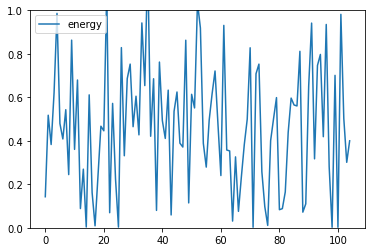

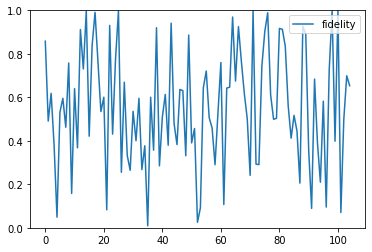

In [2]:
case=1



pptrain=0
exploration=1
game_batch_num=70
sample=6 


lr=0.08
ini=0
runqzero(sample,case,pptrain,exploration,game_batch_num,lr,ini)

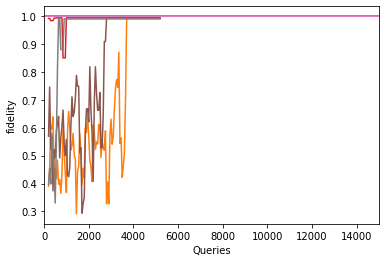

In [5]:
def plote(case):

    y=np.loadtxt('qzeros6c'+str(case)+'fidelity.txt')
    yppo=y.tolist()

    xppo=list(range(len(yppo)))
    
    
    xdata=xppo
    ydata=yppo
    x=[]
    y=[]
    for i in xdata:
        if i>3:
            ymean=np.mean(ydata[int(i)-3:int(i)])
            y.append(ymean)
            x.append(i*50)    # from "epsoide" to "queries",  Qzero need to multiply 50=10(n_playout)*5(N_modular)
    plt.plot([1]*15000)
    plt.plot(x, y)   
    plt.xlabel("Queries")
    plt.ylabel("fidelity")
    plt.xlim(0,15000)
    

plote(1)
plote(2)
plote(3)
plote(4)


